In [59]:
# ! module load mambaforge
# ! mamba create -n wind_forecasting_env python=3.12
# ! mamba activate wind_forecasting_env
# ! conda install -c conda-forge jupyterlab mpi4py impi_rt
# ! pip install ./OpenOA # have to change pyproject.toml to allow for python 3.12.7
# ! pip install floris polars windrose netCDF4 statsmodels h5pyd seaborn pyarrow memory_profiler

#%load_ext memory_profiler
from data_loader import DataLoader
from data_filter import DataFilter
from data_inspector import DataInspector
from openoa.utils import qa, plot, filters, power_curve, imputing
import polars.selectors as cs
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import platform
import os
import re
import pandas as pd
import logging
from datetime import timedelta

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# import datetime
# t2 = datetime.datetime(2022, 3, 1, 12, 0, 55)

## Print NetCDF Data Structure, Load Data, Transform Datetime Columns

In [60]:
PLOT = False
RELOAD_DATA = False

if platform == "darwin":
    DATA_DIR = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data"
    # PL_SAVE_PATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data/kp.turbine.zo2.b0.raw.parquet"
    # FILE_SIGNATURE = "kp.turbine.z02.b0.*.*.*.nc"
    PL_SAVE_PATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data/kp.turbine.zo2.b0.raw.parquet"
    FILE_SIGNATURE = "kp.turbine.z02.b0.202203*.*.*.nc"
    MULTIPROCESSOR = "cf"
    TURBINE_INPUT_FILEPATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/ge_282_127.yaml"
    FARM_INPUT_FILEPATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/gch_KP_v4.yaml"
    FEATURES = ["time", "turbine_id", "turbine_status", "wind_direction", "wind_speed", "power_output", "nacelle_direction"]
    WIDE_FORMAT = False
    COLUMN_MAPPING = {"time": "date",
                            "turbine_id": "turbine_id",
                            "turbine_status": "WTUR.TurSt",
                            "wind_direction": "WMET.HorWdDir",
                            "wind_speed": "WMET.HorWdSpd",
                            "power_output": "WTUR.W",
                            "nacelle_direction": "WNAC.Dir"
                            }
elif platform == "linux":
    DATA_DIR = "/pl/active/paolab/awaken_data/kp.turbine.z02.b0/"
    PL_SAVE_PATH = "/scratch/alpine/aohe7145/awaken_data/kp.turbine.zo2.b0.raw.parquet"
    FILE_SIGNATURE = "kp.turbine.z02.b0.*.*.*.nc"
    MULTIPROCESSOR = "mpi"
    TURBINE_INPUT_FILEPATH = "/projects/aohe7145/toolboxes/wind-forecasting/examples/inputs/ge_282_127.yaml"
    FARM_INPUT_FILEPATH = "/projects/aohe7145/toolboxes/wind-forecasting/examples/inputs/gch_KP_v4.yaml"
    FEATURES = ["time", "turbine_id", "turbine_status", "wind_direction", "wind_speed", "power_output", "nacelle_direction"]
    WIDE_FORMAT = False
    COLUMN_MAPPING = {"time": "date",
                            "turbine_id": "turbine_id",
                            "turbine_status": "WTUR.TurSt",
                            "wind_direction": "WMET.HorWdDir",
                            "wind_speed": "WMET.HorWdSpd",
                            "power_output": "WTUR.W",
                            "nacelle_direction": "WNAC.Dir"
                            }

DT = 5
if FILE_SIGNATURE.endswith(".nc"):
    DATA_FORMAT = "netcdf"
elif FILE_SIGNATURE.endswith(".csv"):
    DATA_FORMAT = "csv"
else:
    raise ValueError("Invalid file signature. Please specify either '*.nc' or '*.csv'.")
# turbine_ids =  ["wt028", "wt033", "wt073"]
                         
data_loader = DataLoader(
                data_dir=DATA_DIR,
                file_signature=FILE_SIGNATURE,
                save_path=PL_SAVE_PATH,
                multiprocessor=MULTIPROCESSOR,
                dt=DT,
                desired_feature_types=FEATURES,
                data_format=DATA_FORMAT,
                column_mapping=COLUMN_MAPPING,
                wide_format=WIDE_FORMAT,
                ffill_limit=int(60 * 60 * 10 // DT))

In [61]:
data_loader.print_netcdf_structure(data_loader.file_paths[0])

2024-10-22 10:52:37,414 - INFO - 📊 NetCDF File: kp.turbine.z02.b0.20220326.000000.wt060.nc
2024-10-22 10:52:37,414 - INFO - 
🌐 Global Attributes:
2024-10-22 10:52:37,415 - INFO - 
📏 Dimensions:
2024-10-22 10:52:37,415 - INFO -   date: 228700
2024-10-22 10:52:37,415 - INFO -   string7: 7
2024-10-22 10:52:37,415 - INFO - 
🔢 Variables:
2024-10-22 10:52:37,415 - INFO -   Flag:
2024-10-22 10:52:37,416 - INFO -     Dimensions: ('date', 'string7')
2024-10-22 10:52:37,416 - INFO -     Shape: (228700, 7)
2024-10-22 10:52:37,416 - INFO -     Data type: |S1
2024-10-22 10:52:37,416 - INFO -     Attributes:
2024-10-22 10:52:37,416 - INFO -       _Encoding: utf-8
2024-10-22 10:52:37,416 - INFO -   date:
2024-10-22 10:52:37,417 - INFO -     Dimensions: ('date',)
2024-10-22 10:52:37,417 - INFO -     Shape: (228700,)
2024-10-22 10:52:37,417 - INFO -     Data type: int32
2024-10-22 10:52:37,417 - INFO -     Attributes:
2024-10-22 10:52:37,417 - INFO -       units: milliseconds since 2022-03-26 00:00:00.

In [62]:
if not RELOAD_DATA and os.path.exists(data_loader.save_path):
     # Note that the order of the columns in the provided schema must match the order of the columns in the CSV being read.
    schema = pl.Schema(dict(sorted(({**{"time": pl.Datetime(time_unit="ms")},
                **{
                    f"{feat}_{tid}": pl.Float64
                    for feat in FEATURES 
                    for tid in [f"wt{d+1:03d}" for d in range(88)]}
                }).items())))
    logging.info("🔄 Loading existing Parquet file")
    df_query = pl.scan_parquet(source=data_loader.save_path)
    logging.info("✅ Loaded existing Parquet file successfully")
    data_loader.available_features = sorted(df_query.collect_schema().names())
    data_loader.turbine_ids = sorted(set(col.split("_")[-1] for col in data_loader.available_features if "wt" in col))
else:
    logging.info("🔄 Processing new data files")
    df_query = data_loader.read_multi_files()
        
    if df_query is not None:
        # Perform any additional operations on df_query if needed
        logging.info("✅ Data processing completed successfully")
    else:
        logging.warning("⚠️  No data was processed")

2024-10-22 10:52:37,444 - INFO - 🔄 Loading existing Parquet file
2024-10-22 10:52:37,444 - INFO - ✅ Loaded existing Parquet file successfully


## Plot Wind Farm, Data Distributions

In [63]:
data_inspector = DataInspector(turbine_input_filepath=TURBINE_INPUT_FILEPATH, farm_input_filepath=FARM_INPUT_FILEPATH)

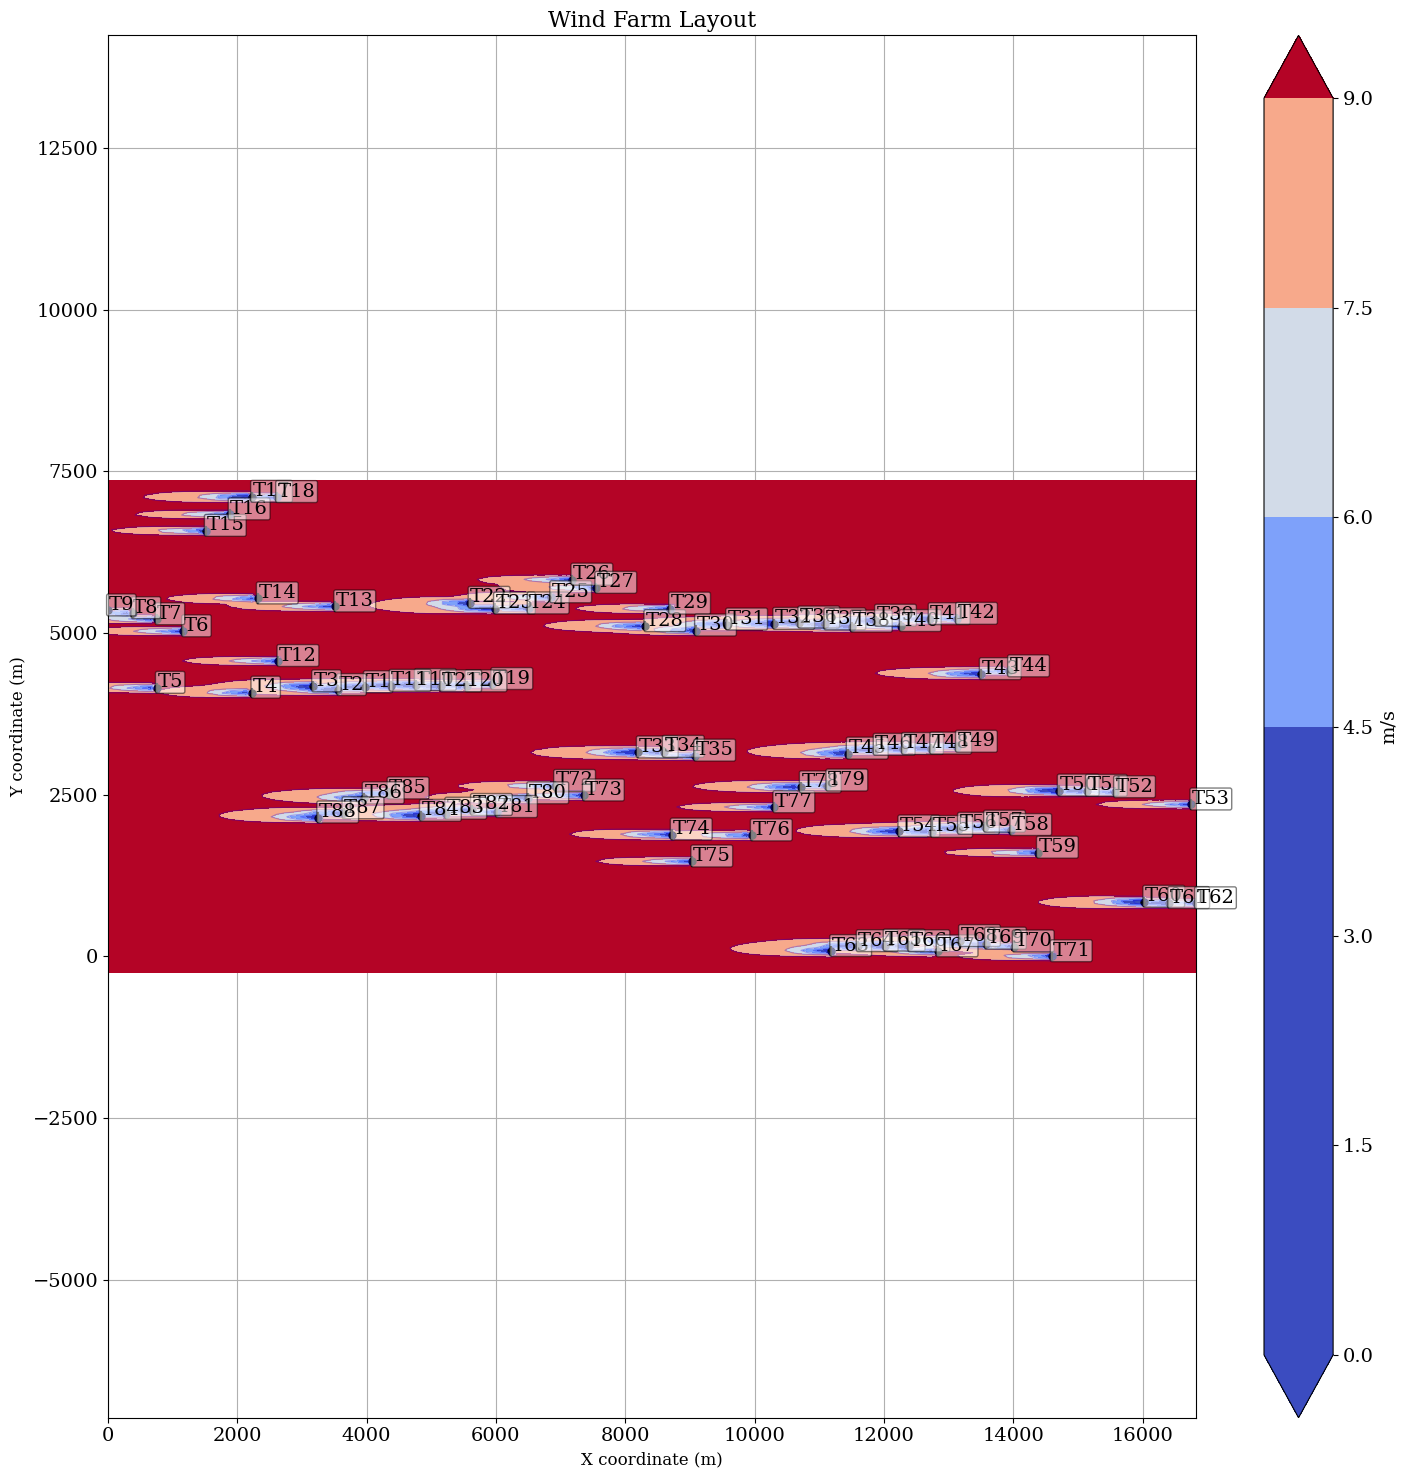

In [64]:
if PLOT or True:
    data_inspector.plot_wind_farm()

In [65]:
if PLOT:
    data_inspector.plot_wind_speed_power(df_query, turbine_ids=["wt073"])

In [66]:
if PLOT:
    data_inspector.plot_wind_speed_weibull(df_query, turbine_ids="all")

In [67]:
if PLOT:
    data_inspector.plot_wind_rose(df_query, turbine_ids="all")

In [68]:
if PLOT:
    data_inspector.plot_correlation(df_query, 
    DataInspector.get_features(df_query, feature_types=["wind_speed", "wind_direction", "nacelle_direction"], turbine_ids=["wt073"]))

In [69]:
if PLOT:
    data_inspector.plot_boxplot_wind_speed_direction(df_query, turbine_ids=["wt073"])

In [70]:
if PLOT:
    data_inspector.plot_time_series(df_query, turbine_ids=["wt073"])

## OpenOA Data Preparation & Inspection

In [71]:
ws_cols = DataInspector.get_features(df_query, "wind_speed")
wd_cols = DataInspector.get_features(df_query, "wind_direction")
pwr_cols = DataInspector.get_features(df_query, "power_output")

In [72]:
print(f"Features of interest = {data_loader.desired_feature_types}")
print(f"Available features = {data_loader.available_features}")
# qa.describe(DataInspector.collect_data(df=df_query))

Features of interest = ['time', 'turbine_id', 'turbine_status', 'wind_direction', 'wind_speed', 'power_output', 'nacelle_direction']
Available features = ['nacelle_direction_wt001', 'nacelle_direction_wt002', 'nacelle_direction_wt003', 'nacelle_direction_wt004', 'nacelle_direction_wt005', 'nacelle_direction_wt006', 'nacelle_direction_wt007', 'nacelle_direction_wt008', 'nacelle_direction_wt009', 'nacelle_direction_wt010', 'nacelle_direction_wt011', 'nacelle_direction_wt012', 'nacelle_direction_wt013', 'nacelle_direction_wt014', 'nacelle_direction_wt015', 'nacelle_direction_wt016', 'nacelle_direction_wt017', 'nacelle_direction_wt018', 'nacelle_direction_wt019', 'nacelle_direction_wt020', 'nacelle_direction_wt021', 'nacelle_direction_wt022', 'nacelle_direction_wt023', 'nacelle_direction_wt024', 'nacelle_direction_wt025', 'nacelle_direction_wt026', 'nacelle_direction_wt027', 'nacelle_direction_wt028', 'nacelle_direction_wt029', 'nacelle_direction_wt030', 'nacelle_direction_wt031', 'nacelle

In [73]:
if PLOT:
    plot.column_histograms(DataInspector.collect_data(df=df_query, 
    feature_types=DataInspector.get_features(df_query, ["wind_speed", "wind_direction", "power_output", "nacelle_direction"])))

In [74]:
data_filter = DataFilter(turbine_availability_col=None, turbine_status_col="turbine_status", multiprocessor=MULTIPROCESSOR)

In [75]:
# df_query.filter(pl.col("time") <= t2).collect()

### Nullify Inoperational Turbine Rows

In [76]:
# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
# df_query = data_filter.filter_inoperational(df_query, status_codes=[1], include_nan=False)
status_codes = [1]
mask = lambda tid: pl.col(f"turbine_status_{tid}").is_in(status_codes) | pl.col(f"turbine_status_{tid}").is_null()
features = ws_cols
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, ws_cols + wd_cols, ["wind_speed", "wind_direction"], ["Wind Speed [m/s]", "Wind Direction [deg]"])


Feature wind_speed_wt001 has 58.14841295472492 % unfiltered values.
Feature wind_speed_wt002 has 52.506622411472506 % unfiltered values.
Feature wind_speed_wt003 has 58.01307121215798 % unfiltered values.
Feature wind_speed_wt004 has 58.3918414130798 % unfiltered values.
Feature wind_speed_wt005 has 57.80921854611233 % unfiltered values.
Feature wind_speed_wt006 has 53.76819413046198 % unfiltered values.
Feature wind_speed_wt007 has 57.92999938396173 % unfiltered values.
Feature wind_speed_wt008 has 58.35898603833252 % unfiltered values.
Feature wind_speed_wt009 has 55.23660536774685 % unfiltered values.
Feature wind_speed_wt010 has 58.12078457141471 % unfiltered values.
Feature wind_speed_wt011 has 57.88370317409055 % unfiltered values.
Feature wind_speed_wt012 has 58.182388399065864 % unfiltered values.
Feature wind_speed_wt013 has 58.25089932254457 % unfiltered values.
Feature wind_speed_wt014 has 58.371120125597145 % unfiltered values.
Feature wind_speed_wt015 has 57.83815367728181

In [77]:
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
# fill out_of_range measurements with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, ws_cols + wd_cols)

JS Score for feature wind_speed_wt001 = 0.08484674364942897
JS Score for feature wind_speed_wt002 = 0.08065476542422048
JS Score for feature wind_speed_wt003 = 0.08347705862156272
JS Score for feature wind_speed_wt004 = 0.08317629914430018
JS Score for feature wind_speed_wt005 = 0.0942217789951301
JS Score for feature wind_speed_wt006 = 0.09331145098270074
JS Score for feature wind_speed_wt007 = 0.08991060951410215
JS Score for feature wind_speed_wt008 = 0.0792979142390128
JS Score for feature wind_speed_wt009 = 0.0741001176669463
JS Score for feature wind_speed_wt010 = 0.08518450477405964
JS Score for feature wind_speed_wt011 = 0.0758143123155192
JS Score for feature wind_speed_wt012 = 0.08766458870767954
JS Score for feature wind_speed_wt013 = 0.0845022287406298
JS Score for feature wind_speed_wt014 = 0.07766692401403985
JS Score for feature wind_speed_wt015 = 0.08655339535140186
JS Score for feature wind_speed_wt016 = 0.09211487652414795
JS Score for feature wind_speed_wt017 = 0.085

In [78]:
df_query.head().collect()
# df_query.filter(pl.col("time") <= t2).collect()

nacelle_direction_wt001,nacelle_direction_wt002,nacelle_direction_wt003,nacelle_direction_wt004,nacelle_direction_wt005,nacelle_direction_wt006,nacelle_direction_wt007,nacelle_direction_wt008,nacelle_direction_wt009,nacelle_direction_wt010,nacelle_direction_wt011,nacelle_direction_wt012,nacelle_direction_wt013,nacelle_direction_wt014,nacelle_direction_wt015,nacelle_direction_wt016,nacelle_direction_wt017,nacelle_direction_wt018,nacelle_direction_wt019,nacelle_direction_wt020,nacelle_direction_wt021,nacelle_direction_wt022,nacelle_direction_wt023,nacelle_direction_wt024,nacelle_direction_wt025,nacelle_direction_wt026,nacelle_direction_wt027,nacelle_direction_wt028,nacelle_direction_wt029,nacelle_direction_wt030,nacelle_direction_wt031,nacelle_direction_wt032,nacelle_direction_wt033,nacelle_direction_wt034,nacelle_direction_wt035,nacelle_direction_wt036,nacelle_direction_wt037,…,wind_speed_wt052,wind_speed_wt053,wind_speed_wt054,wind_speed_wt055,wind_speed_wt056,wind_speed_wt057,wind_speed_wt058,wind_speed_wt059,wind_speed_wt060,wind_speed_wt061,wind_speed_wt062,wind_speed_wt063,wind_speed_wt064,wind_speed_wt065,wind_speed_wt066,wind_speed_wt067,wind_speed_wt068,wind_speed_wt069,wind_speed_wt070,wind_speed_wt071,wind_speed_wt072,wind_speed_wt073,wind_speed_wt074,wind_speed_wt075,wind_speed_wt076,wind_speed_wt077,wind_speed_wt078,wind_speed_wt079,wind_speed_wt080,wind_speed_wt081,wind_speed_wt082,wind_speed_wt083,wind_speed_wt084,wind_speed_wt085,wind_speed_wt086,wind_speed_wt087,wind_speed_wt088
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,209.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.021093,8.270353,6.963817,6.445257,6.220496,4.500181,5.450901,5.352233,9.499508,7.855479,8.870214,5.862917,6.421623,6.142904,6.54178,7.106257,6.367146,6.741147,7.10255,6.8440237,6.4179883,6.374405,5.521564,6.569147,6.168147,5.405053,2.6379,6.0583,6.908477,null,5.02322,5.197799,5.468552,6.799896,3.756544,7.152627,6.997062
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.021093,8.270353,6.963817,6.445257,5.110387,7.019245,6.029548,5.080723,9.330383,7.054394,9.076818,6.197019,6.078082,6.42344,6.301889,7.364848,6.890049,6.483469,6.737479,7.072907,6.902947,6.519901,5.645601,6.569147,6.168147,5.405053,2.6379,6.0583,6.908477,null,5.02322,5.197799,5.468552,6.799896,3.756544,7.152627,6.997062
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.119235,7.249273,6.434347,6.367146,6.004409,7.647892,6.151917,5.180297,8.077567,7.275337,8.020494,6.365332,5.41739,6.378035,6.301889,7.364848,6.890049,6.483469,6.737479,7.072907,6.902947,6.519901,5.645601,6.569147,6.168147,5.405053,2.6379,5.72381,7.409687,null,5.78794,5.072004,5.716692,6.492573,3.442897,7.353647,6.958279
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,5.950606,6.832987,6.323628,6.461628,5.526871,7.984393,5.952399,5.399766,8.241659,8.220631,8.350815,6.336315,5.802208,5.030184,6.263882,6.529016,7.104403,6.834826,6.65504,6.851384,5.768331,6.358075,5.229326,6.842185,6.292836,4.52929,2.549927,6.276546,5.986466,null,5.120864,4.737289,5.445607,6.060098,2.788936,6.67334

### Wind Speed Range Filter

In [79]:

# check for wind speed values that are outside of the acceptable range
if RELOAD_DATA or not os.path.exists(os.path.join(DATA_DIR, "out_of_range.npy")):
    ws = DataInspector.collect_data(df=df_query, feature_types="wind_speed")
    out_of_range = (filters.range_flag(ws, lower=0, upper=70) & ~ws.isna()).values # range flag includes formerly null values as nan
    del ws
    np.save(os.path.join(DATA_DIR, "out_of_range.npy"), out_of_range)
else:
  out_of_range = np.load(os.path.join(DATA_DIR, "out_of_range.npy"))
# qa.describe(DataInspector.collect_data(df=df_query, feature_types="wind_speed", mask=np.any(out_of_range, axis=1)))

# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
mask = lambda tid: ~out_of_range[:, data_loader.turbine_ids.index(tid)]
features = ws_cols
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, ws_cols, ["wind_speed"], ["Wind Speed [m/s]"])



Feature wind_speed_wt001 has 100.0 % unfiltered values.
Feature wind_speed_wt002 has 100.0 % unfiltered values.
Feature wind_speed_wt003 has 100.0 % unfiltered values.
Feature wind_speed_wt004 has 100.0 % unfiltered values.
Feature wind_speed_wt005 has 100.0 % unfiltered values.
Feature wind_speed_wt006 has 100.0 % unfiltered values.
Feature wind_speed_wt007 has 100.0 % unfiltered values.
Feature wind_speed_wt008 has 100.0 % unfiltered values.
Feature wind_speed_wt009 has 100.0 % unfiltered values.
Feature wind_speed_wt010 has 100.0 % unfiltered values.
Feature wind_speed_wt011 has 100.0 % unfiltered values.
Feature wind_speed_wt012 has 100.0 % unfiltered values.
Feature wind_speed_wt013 has 100.0 % unfiltered values.
Feature wind_speed_wt014 has 100.0 % unfiltered values.
Feature wind_speed_wt015 has 100.0 % unfiltered values.
Feature wind_speed_wt016 has 100.0 % unfiltered values.
Feature wind_speed_wt017 has 100.0 % unfiltered values.
Feature wind_speed_wt018 has 100.0 % unfiltered 

In [80]:
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
# fill out_of_range measurements with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, ws_cols)

JS Score for feature wind_speed_wt001 = 0.0
JS Score for feature wind_speed_wt002 = 0.0
JS Score for feature wind_speed_wt003 = 0.0
JS Score for feature wind_speed_wt004 = 0.0
JS Score for feature wind_speed_wt005 = 0.0
JS Score for feature wind_speed_wt006 = 0.0
JS Score for feature wind_speed_wt007 = 0.0
JS Score for feature wind_speed_wt008 = 0.0
JS Score for feature wind_speed_wt009 = 0.0
JS Score for feature wind_speed_wt010 = 0.0
JS Score for feature wind_speed_wt011 = 0.0
JS Score for feature wind_speed_wt012 = 0.0
JS Score for feature wind_speed_wt013 = 0.0
JS Score for feature wind_speed_wt014 = 0.0
JS Score for feature wind_speed_wt015 = 0.0
JS Score for feature wind_speed_wt016 = 0.0
JS Score for feature wind_speed_wt017 = 0.0
JS Score for feature wind_speed_wt018 = 0.0
JS Score for feature wind_speed_wt019 = 0.0
JS Score for feature wind_speed_wt020 = 0.0
JS Score for feature wind_speed_wt021 = 0.0
JS Score for feature wind_speed_wt022 = 0.0
JS Score for feature wind_speed_

In [81]:
del out_of_range 
df_query.head().collect()

nacelle_direction_wt001,nacelle_direction_wt002,nacelle_direction_wt003,nacelle_direction_wt004,nacelle_direction_wt005,nacelle_direction_wt006,nacelle_direction_wt007,nacelle_direction_wt008,nacelle_direction_wt009,nacelle_direction_wt010,nacelle_direction_wt011,nacelle_direction_wt012,nacelle_direction_wt013,nacelle_direction_wt014,nacelle_direction_wt015,nacelle_direction_wt016,nacelle_direction_wt017,nacelle_direction_wt018,nacelle_direction_wt019,nacelle_direction_wt020,nacelle_direction_wt021,nacelle_direction_wt022,nacelle_direction_wt023,nacelle_direction_wt024,nacelle_direction_wt025,nacelle_direction_wt026,nacelle_direction_wt027,nacelle_direction_wt028,nacelle_direction_wt029,nacelle_direction_wt030,nacelle_direction_wt031,nacelle_direction_wt032,nacelle_direction_wt033,nacelle_direction_wt034,nacelle_direction_wt035,nacelle_direction_wt036,nacelle_direction_wt037,…,wind_speed_wt052,wind_speed_wt053,wind_speed_wt054,wind_speed_wt055,wind_speed_wt056,wind_speed_wt057,wind_speed_wt058,wind_speed_wt059,wind_speed_wt060,wind_speed_wt061,wind_speed_wt062,wind_speed_wt063,wind_speed_wt064,wind_speed_wt065,wind_speed_wt066,wind_speed_wt067,wind_speed_wt068,wind_speed_wt069,wind_speed_wt070,wind_speed_wt071,wind_speed_wt072,wind_speed_wt073,wind_speed_wt074,wind_speed_wt075,wind_speed_wt076,wind_speed_wt077,wind_speed_wt078,wind_speed_wt079,wind_speed_wt080,wind_speed_wt081,wind_speed_wt082,wind_speed_wt083,wind_speed_wt084,wind_speed_wt085,wind_speed_wt086,wind_speed_wt087,wind_speed_wt088
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,209.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.021093,8.270353,6.963817,6.445257,6.220496,4.500181,5.450901,5.352233,9.499508,7.855479,8.870214,5.862917,6.421623,6.142904,6.54178,7.106257,6.367146,6.741147,7.10255,6.8440237,6.4179883,6.374405,5.521564,6.569147,6.168147,5.405053,2.6379,6.0583,6.908477,null,5.02322,5.197799,5.468552,6.799896,3.756544,7.152627,6.997062
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.021093,8.270353,6.963817,6.445257,5.110387,7.019245,6.029548,5.080723,9.330383,7.054394,9.076818,6.197019,6.078082,6.42344,6.301889,7.364848,6.890049,6.483469,6.737479,7.072907,6.902947,6.519901,5.645601,6.569147,6.168147,5.405053,2.6379,6.0583,6.908477,null,5.02322,5.197799,5.468552,6.799896,3.756544,7.152627,6.997062
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.119235,7.249273,6.434347,6.367146,6.004409,7.647892,6.151917,5.180297,8.077567,7.275337,8.020494,6.365332,5.41739,6.378035,6.301889,7.364848,6.890049,6.483469,6.737479,7.072907,6.902947,6.519901,5.645601,6.569147,6.168147,5.405053,2.6379,5.72381,7.409687,null,5.78794,5.072004,5.716692,6.492573,3.442897,7.353647,6.958279
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,5.950606,6.832987,6.323628,6.461628,5.526871,7.984393,5.952399,5.399766,8.241659,8.220631,8.350815,6.336315,5.802208,5.030184,6.263882,6.529016,7.104403,6.834826,6.65504,6.851384,5.768331,6.358075,5.229326,6.842185,6.292836,4.52929,2.549927,6.276546,5.986466,null,5.120864,4.737289,5.445607,6.060098,2.788936,6.67334

### Power Curve Window Range Filter

In [82]:
# apply a window range filter to remove data with power values outside of the window from 20 to 3000 kW for wind speeds between 5 and 40 m/s.
# identifies when turbine is shut down, filtering for normal turbine operation
if RELOAD_DATA or not os.path.exists(os.path.join(DATA_DIR, "out_of_window.npy")):
  out_of_window = np.stack([(filters.window_range_flag(window_col=DataInspector.collect_data(df=df_query, 
                                                                                    feature_types=["wind_speed"], 
                                                                                    turbine_ids=[tid])[f"wind_speed_{tid}"],
                                                    window_start=5., window_end=40., 
                                                    value_col=DataInspector.collect_data(df=df_query, 
                                                                                    feature_types=["power_output"], 
                                                                                    turbine_ids=[tid])[f"power_output_{tid}"],
                                                    value_min=20., value_max=3000.)
                        & df_query.select(no_nulls=pl.all_horizontal(pl.col(f"wind_speed_{tid}").is_not_null(), pl.col(f"power_output_{tid}").is_not_null()))\
                                  .collect(streaming=True).to_pandas()["no_nulls"]
                                #   & ~DataInspector.collect_data(df=df_query, feature_types="wind_speed", turbine_ids=tid).isna()
                                #   & ~DataInspector.collect_data(df=df_query, feature_types="power_output", turbine_ids=tid).isna()
                                  ).values for tid in data_loader.turbine_ids], axis=1)

  np.save(os.path.join(DATA_DIR, "out_of_window.npy"), out_of_window)
else:
  out_of_window = np.load(os.path.join(DATA_DIR, "out_of_window.npy"))

# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
mask = lambda tid: ~out_of_window[:, data_loader.turbine_ids.index(tid)]
features = ws_cols 
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, features, features, ["Wind Speed [m/s]"])



Feature wind_speed_wt001 has 99.31769093919702 % unfiltered values.
Feature wind_speed_wt002 has 99.29808972130802 % unfiltered values.
Feature wind_speed_wt003 has 99.29808972130802 % unfiltered values.
Feature wind_speed_wt004 has 99.34569267903845 % unfiltered values.
Feature wind_speed_wt005 has 99.21893813668956 % unfiltered values.
Feature wind_speed_wt006 has 98.97270950435055 % unfiltered values.
Feature wind_speed_wt007 has 98.98054999150614 % unfiltered values.
Feature wind_speed_wt008 has 99.04868755845364 % unfiltered values.
Feature wind_speed_wt009 has 99.48290120426148 % unfiltered values.
Feature wind_speed_wt010 has 99.11141145569844 % unfiltered values.
Feature wind_speed_wt011 has 99.40729650668962 % unfiltered values.
Feature wind_speed_wt012 has 99.38750861053501 % unfiltered values.
Feature wind_speed_wt013 has 99.35465323578771 % unfiltered values.
Feature wind_speed_wt014 has 99.31806429572823 % unfiltered values.
Feature wind_speed_wt015 has 99.321051147978 % u

In [83]:
if PLOT:
    # plot values that are outside of power-wind speed range
    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed").to_numpy().flatten(),
        DataInspector.collect_data(df=df_query, feature_types="power_output").to_numpy().flatten(),
        flag=out_of_window.flatten(),
        flag_labels=("Outside Acceptable Window", "Acceptable Power Curve Points"),
        xlim=(-1, 15),
        ylim=(-100, 3000),
        legend=True,
        scatter_kwargs=dict(alpha=0.4, s=10)
    )

In [84]:
# fill cells corresponding to values that are outside of power-wind speed window range with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, features)

JS Score for feature wind_speed_wt001 = 1.4455771262594949e-05
JS Score for feature wind_speed_wt002 = 1.4314513373476278e-05
JS Score for feature wind_speed_wt003 = 1.1423298638840537e-05
JS Score for feature wind_speed_wt004 = 1.2228418950660973e-05
JS Score for feature wind_speed_wt005 = 1.6069765177509057e-05
JS Score for feature wind_speed_wt006 = 3.997756935766834e-05
JS Score for feature wind_speed_wt007 = 1.7384275930975316e-05
JS Score for feature wind_speed_wt008 = 1.870078700191912e-05
JS Score for feature wind_speed_wt009 = 9.789507544200802e-06
JS Score for feature wind_speed_wt010 = 1.69520338427671e-05
JS Score for feature wind_speed_wt011 = 1.039977240189968e-05
JS Score for feature wind_speed_wt012 = 1.1267192463124376e-05
JS Score for feature wind_speed_wt013 = 1.2282839964314608e-05
JS Score for feature wind_speed_wt014 = 1.3190111552514432e-05
JS Score for feature wind_speed_wt015 = 1.1504397524313086e-05
JS Score for feature wind_speed_wt016 = 1.7978647798504698e-0

In [85]:
del out_of_window
df_query.head().collect()

nacelle_direction_wt001,nacelle_direction_wt002,nacelle_direction_wt003,nacelle_direction_wt004,nacelle_direction_wt005,nacelle_direction_wt006,nacelle_direction_wt007,nacelle_direction_wt008,nacelle_direction_wt009,nacelle_direction_wt010,nacelle_direction_wt011,nacelle_direction_wt012,nacelle_direction_wt013,nacelle_direction_wt014,nacelle_direction_wt015,nacelle_direction_wt016,nacelle_direction_wt017,nacelle_direction_wt018,nacelle_direction_wt019,nacelle_direction_wt020,nacelle_direction_wt021,nacelle_direction_wt022,nacelle_direction_wt023,nacelle_direction_wt024,nacelle_direction_wt025,nacelle_direction_wt026,nacelle_direction_wt027,nacelle_direction_wt028,nacelle_direction_wt029,nacelle_direction_wt030,nacelle_direction_wt031,nacelle_direction_wt032,nacelle_direction_wt033,nacelle_direction_wt034,nacelle_direction_wt035,nacelle_direction_wt036,nacelle_direction_wt037,…,wind_speed_wt052,wind_speed_wt053,wind_speed_wt054,wind_speed_wt055,wind_speed_wt056,wind_speed_wt057,wind_speed_wt058,wind_speed_wt059,wind_speed_wt060,wind_speed_wt061,wind_speed_wt062,wind_speed_wt063,wind_speed_wt064,wind_speed_wt065,wind_speed_wt066,wind_speed_wt067,wind_speed_wt068,wind_speed_wt069,wind_speed_wt070,wind_speed_wt071,wind_speed_wt072,wind_speed_wt073,wind_speed_wt074,wind_speed_wt075,wind_speed_wt076,wind_speed_wt077,wind_speed_wt078,wind_speed_wt079,wind_speed_wt080,wind_speed_wt081,wind_speed_wt082,wind_speed_wt083,wind_speed_wt084,wind_speed_wt085,wind_speed_wt086,wind_speed_wt087,wind_speed_wt088
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,209.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.021093,8.270353,6.963817,6.445257,6.220496,4.500181,5.450901,5.352233,9.499508,7.855479,8.870214,5.862917,6.421623,6.142904,6.54178,7.106257,6.367146,6.741147,7.10255,6.8440237,6.4179883,6.374405,5.521564,6.569147,6.168147,5.405053,2.6379,6.0583,6.908477,null,5.02322,5.197799,5.468552,6.799896,3.756544,7.152627,6.997062
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.021093,8.270353,6.963817,6.445257,5.110387,7.019245,6.029548,5.080723,9.330383,7.054394,9.076818,6.197019,6.078082,6.42344,6.301889,7.364848,6.890049,6.483469,6.737479,7.072907,6.902947,6.519901,5.645601,6.569147,6.168147,5.405053,2.6379,6.0583,6.908477,null,5.02322,5.197799,5.468552,6.799896,3.756544,7.152627,6.997062
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.119235,7.249273,6.434347,6.367146,6.004409,7.647892,6.151917,5.180297,8.077567,7.275337,8.020494,6.365332,5.41739,6.378035,6.301889,7.364848,6.890049,6.483469,6.737479,7.072907,6.902947,6.519901,5.645601,6.569147,6.168147,5.405053,2.6379,5.72381,7.409687,null,5.78794,5.072004,5.716692,6.492573,3.442897,7.353647,6.958279
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,5.950606,6.832987,6.323628,6.461628,5.526871,7.984393,5.952399,5.399766,8.241659,8.220631,8.350815,6.336315,5.802208,5.030184,6.263882,6.529016,7.104403,6.834826,6.65504,6.851384,5.768331,6.358075,5.229326,6.842185,6.292836,4.52929,2.549927,6.276546,5.986466,null,5.120864,4.737289,5.445607,6.060098,2.788936,6.67334

### Power Curve Bin Filter

In [86]:
# apply a bin filter to remove data with power values outside of an envelope around median power curve at each wind speed
if RELOAD_DATA or not os.path.exists(os.path.join(DATA_DIR, "bin_outliers.npy")):
  bin_outliers = np.stack([(filters.bin_filter(
                                    bin_col=f"power_output_{tid}", 
                                    value_col=f"wind_speed_{tid}", 
                                    bin_width=50, threshold=3,
                                    center_type="median", 
                                    bin_min=20., bin_max=0.90*(df_query.select(f"power_output_{tid}").max().collect().item() or 3000.),
                                    threshold_type="scalar", direction="below",
                                    data=DataInspector.collect_data(df=df_query, 
                                                                    feature_types=["wind_speed", "power_output"], 
                                                                    turbine_ids=[tid])
                                    )
                                  & df_query.select(no_nulls=pl.all_horizontal(pl.col(f"wind_speed_{tid}").is_not_null(), pl.col(f"power_output_{tid}").is_not_null()))\
                                    .collect().to_pandas()["no_nulls"]
                                    ).values for tid in data_loader.turbine_ids], axis=1)
  np.save(os.path.join(DATA_DIR, "bin_outliers.npy"), bin_outliers)
else:
  bin_outliers = np.load(os.path.join(DATA_DIR, "bin_outliers.npy"))

# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
mask = lambda tid: ~bin_outliers[:, data_loader.turbine_ids.index(tid)]
# TODO save filters to npy files and only reload if necessary
features = ws_cols
DataInspector.print_pc_unfiltered_vals(df_query, features, mask)

if PLOT:
    data_inspector.plot_filtered_vs_unfiltered(df_query, mask, features, features, ["Wind Speed [m/s]"])

Feature wind_speed_wt001 has 99.95557057278492 % unfiltered values.
Feature wind_speed_wt002 has 99.89714027564914 % unfiltered values.
Feature wind_speed_wt003 has 99.94829012042615 % unfiltered values.
Feature wind_speed_wt004 has 99.98357231262635 % unfiltered values.
Feature wind_speed_wt005 has 99.99159947804756 % unfiltered values.
Feature wind_speed_wt006 has 99.98506573875123 % unfiltered values.
Feature wind_speed_wt007 has 99.95631728584736 % unfiltered values.
Feature wind_speed_wt008 has 99.88388611879084 % unfiltered values.
Feature wind_speed_wt009 has 99.97797196465808 % unfiltered values.
Feature wind_speed_wt010 has 99.90927436291375 % unfiltered values.
Feature wind_speed_wt011 has 99.93895620714567 % unfiltered values.
Feature wind_speed_wt012 has 99.97629186026758 % unfiltered values.
Feature wind_speed_wt013 has 99.97591850373637 % unfiltered values.
Feature wind_speed_wt014 has 99.98898598232904 % unfiltered values.
Feature wind_speed_wt015 has 99.96826469484638 %

In [87]:
if PLOT:
    # plot values outside the power-wind speed bin filter
    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed").to_numpy().flatten(),
        DataInspector.collect_data(df=df_query, feature_types="power_output").to_numpy().flatten(),
        flag=bin_outliers.flatten(),
        flag_labels=("Anomylous Data", "Normal Wind Speed Sensor Operation"),
        xlim=(-1, 15),
        ylim=(-100, 3000),
        legend=True,
        scatter_kwargs=dict(alpha=0.4, s=10)
    )

In [88]:
# fill cells corresponding to values that are outside of power-wind speed bins with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
threshold = 0.01
df_query = data_filter.conditional_filter(df_query, threshold, mask, features)

JS Score for feature wind_speed_wt001 = 8.934516450630259e-08
JS Score for feature wind_speed_wt002 = 5.319964651449921e-07
JS Score for feature wind_speed_wt003 = 1.317492898368933e-07
JS Score for feature wind_speed_wt004 = 1.757784441437036e-08
JS Score for feature wind_speed_wt005 = 7.526580593503986e-09
JS Score for feature wind_speed_wt006 = 1.954179022972385e-08
JS Score for feature wind_speed_wt007 = 1.2388310954070006e-07
JS Score for feature wind_speed_wt008 = 1.0544528750573078e-06
JS Score for feature wind_speed_wt009 = 2.887669582808973e-08
JS Score for feature wind_speed_wt010 = 3.4564432117584755e-07
JS Score for feature wind_speed_wt011 = 3.2531164452916316e-07
JS Score for feature wind_speed_wt012 = 6.91585147673436e-08
JS Score for feature wind_speed_wt013 = 4.602785799501943e-08
JS Score for feature wind_speed_wt014 = 1.56538593512283e-08
JS Score for feature wind_speed_wt015 = 1.526557381659474e-07
JS Score for feature wind_speed_wt016 = 1.8275150203838903e-07
JS Sc

In [89]:
del bin_outliers
df_query.head().collect()

nacelle_direction_wt001,nacelle_direction_wt002,nacelle_direction_wt003,nacelle_direction_wt004,nacelle_direction_wt005,nacelle_direction_wt006,nacelle_direction_wt007,nacelle_direction_wt008,nacelle_direction_wt009,nacelle_direction_wt010,nacelle_direction_wt011,nacelle_direction_wt012,nacelle_direction_wt013,nacelle_direction_wt014,nacelle_direction_wt015,nacelle_direction_wt016,nacelle_direction_wt017,nacelle_direction_wt018,nacelle_direction_wt019,nacelle_direction_wt020,nacelle_direction_wt021,nacelle_direction_wt022,nacelle_direction_wt023,nacelle_direction_wt024,nacelle_direction_wt025,nacelle_direction_wt026,nacelle_direction_wt027,nacelle_direction_wt028,nacelle_direction_wt029,nacelle_direction_wt030,nacelle_direction_wt031,nacelle_direction_wt032,nacelle_direction_wt033,nacelle_direction_wt034,nacelle_direction_wt035,nacelle_direction_wt036,nacelle_direction_wt037,…,wind_speed_wt052,wind_speed_wt053,wind_speed_wt054,wind_speed_wt055,wind_speed_wt056,wind_speed_wt057,wind_speed_wt058,wind_speed_wt059,wind_speed_wt060,wind_speed_wt061,wind_speed_wt062,wind_speed_wt063,wind_speed_wt064,wind_speed_wt065,wind_speed_wt066,wind_speed_wt067,wind_speed_wt068,wind_speed_wt069,wind_speed_wt070,wind_speed_wt071,wind_speed_wt072,wind_speed_wt073,wind_speed_wt074,wind_speed_wt075,wind_speed_wt076,wind_speed_wt077,wind_speed_wt078,wind_speed_wt079,wind_speed_wt080,wind_speed_wt081,wind_speed_wt082,wind_speed_wt083,wind_speed_wt084,wind_speed_wt085,wind_speed_wt086,wind_speed_wt087,wind_speed_wt088
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,209.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.021093,8.270353,6.963817,6.445257,6.220496,4.500181,5.450901,5.352233,9.499508,7.855479,8.870214,5.862917,6.421623,6.142904,6.54178,7.106257,6.367146,6.741147,7.10255,6.8440237,6.4179883,6.374405,5.521564,6.569147,6.168147,5.405053,2.6379,6.0583,6.908477,null,5.02322,5.197799,5.468552,6.799896,3.756544,7.152627,6.997062
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.021093,8.270353,6.963817,6.445257,5.110387,7.019245,6.029548,5.080723,9.330383,7.054394,9.076818,6.197019,6.078082,6.42344,6.301889,7.364848,6.890049,6.483469,6.737479,7.072907,6.902947,6.519901,5.645601,6.569147,6.168147,5.405053,2.6379,6.0583,6.908477,null,5.02322,5.197799,5.468552,6.799896,3.756544,7.152627,6.997062
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.119235,7.249273,6.434347,6.367146,6.004409,7.647892,6.151917,5.180297,8.077567,7.275337,8.020494,6.365332,5.41739,6.378035,6.301889,7.364848,6.890049,6.483469,6.737479,7.072907,6.902947,6.519901,5.645601,6.569147,6.168147,5.405053,2.6379,5.72381,7.409687,null,5.78794,5.072004,5.716692,6.492573,3.442897,7.353647,6.958279
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,5.950606,6.832987,6.323628,6.461628,5.526871,7.984393,5.952399,5.399766,8.241659,8.220631,8.350815,6.336315,5.802208,5.030184,6.263882,6.529016,7.104403,6.834826,6.65504,6.851384,5.768331,6.358075,5.229326,6.842185,6.292836,4.52929,2.549927,6.276546,5.986466,null,5.120864,4.737289,5.445607,6.060098,2.788936,6.67334

### Power Curve Fitting

In [90]:
if PLOT:
    # Fit the power curves
    iec_curve = power_curve.IEC(
        windspeed_col="wind_speed", power_col="power_output",
        data=DataInspector.unpivot_dataframe(df_query).select("wind_speed", "power_output").filter(pl.all_horizontal(pl.all().is_not_null())).collect(streaming=True).to_pandas(),
        )

    l5p_curve = power_curve.logistic_5_parametric(
        windspeed_col="wind_speed", power_col="power_output",
        data=DataInspector.unpivot_dataframe(df_query).select("wind_speed", "power_output").filter(pl.all_horizontal(pl.all().is_not_null())).collect(streaming=True).to_pandas(),
        )

    spline_curve = power_curve.gam(
        windspeed_col="wind_speed", power_col="power_output",
        data=DataInspector.unpivot_dataframe(df_query).select("wind_speed", "power_output").filter(pl.all_horizontal(pl.all().is_not_null())).collect(streaming=True).to_pandas(), 
        n_splines=20)

In [91]:
if PLOT:
    fig, ax = plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed").to_numpy().flatten(),
        DataInspector.collect_data(df=df_query, feature_types="power_output").to_numpy().flatten(),
        flag=np.zeros(DataInspector.collect_data(df=df_query, feature_types="wind_speed").shape[0], dtype=bool),
        flag_labels=("", "Filtered Power Curve"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=False,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10),  # optional input for refining plots
        return_fig=True,
    )

    x = np.linspace(0, 20, 100)
    ax.plot(x, iec_curve(x), color="red", label = "IEC", linewidth = 3)
    ax.plot(x, spline_curve(x), color="C1", label = "Spline", linewidth = 3)
    ax.plot(x, l5p_curve(x), color="C2", label = "L5P", linewidth = 3)

    ax.legend()

    fig.tight_layout()
    plt.show()

### Unresponsive Sensor Filter

In [92]:
# find stuck sensor measurements for each turbine and set them to null
# TODO question does unresponsive flag include nan values
# frozen_thresholds = [(data_loader.ffill_limit * i) + 1 for i in range(1, 19)]
# print(frozen_thresholds)
# ws_pcs = []
# wd_pcs = []
# pwr_pcs = []
# for thr in frozen_thresholds:
#     ws_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_speed"), threshold=thr).values
#     wd_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_direction"), threshold=thr).values
#     pwr_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="power_output"), threshold=thr).values

#     # check if wind speed/dir measurements from inoperational turbines differ from fully operational
#     print(f"For a threshold of {thr} for the frozen sensor filters:")
#     ws_pcs.append(DataInspector.print_pc_unfiltered_vals(df_query, ws_cols, lambda tid: ws_frozen_sensor[:, data_loader.turbine_ids.index(tid)]))
#     wd_pcs.append(DataInspector.print_pc_unfiltered_vals(df_query, wd_cols, lambda tid: wd_frozen_sensor[:, data_loader.turbine_ids.index(tid)]))
#     pwr_pcs.append(DataInspector.print_pc_unfiltered_vals(df_query, pwr_cols, lambda tid: pwr_frozen_sensor[:, data_loader.turbine_ids.index(tid)]))

# fig, ax = plt.subplots(3, 1, sharex=True)
# for t_idx in range(len(data_loader.turbine_ids)):
#     ax[0].scatter(x=frozen_thresholds, y=[x[1][t_idx] for x in ws_pcs], label=data_loader.turbine_ids[t_idx])
#     ax[1].scatter(x=frozen_thresholds, y=[x[1][t_idx] for x in wd_pcs], label=data_loader.turbine_ids[t_idx])
#     ax[2].scatter(x=frozen_thresholds, y=[x[1][t_idx] for x in pwr_pcs],label=data_loader.turbine_ids[t_idx])

# h, l = ax[0].get_legend_handles_labels()
# ax[0].legend(h[:len(data_loader.turbine_ids)], l[:len(data_loader.turbine_ids)])
# ax[0].set_title("Percentage of Unfrozen Wind Speed Measurements")
# ax[1].set_title("Percentage of Unfrozen Wind Direction Measurements")
# ax[2].set_title("Percentage of Unfrozen Power Output Measurements")
# qa.describe(pl.concat([DataInspector.collect_data(df=df_query, feature_types=feature_type, mask=mask, to_pandas=False)
#                         for mask, feature_type in zip([ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor], ["wind_speed", "wind_direction", "power_output"])], 
#                             how="horizontal")\
#                                .to_pandas())

# TODO ASK ERIC if necessary
if False:
    thr = data_loader.ffill_limit + 1
    # frozen_sensor = (filters.unresponsive_flag(data=df_query.select(features).collect(streaming=True).to_pandas(), threshold=thr)
                                    # & df_query.select([pl.col(feat).is_not_null().alias(feat) for feat in features])\
                                    #   .collect(streaming=True).to_pandas()
                                    #   ).values
    features = ws_cols + wd_cols
    # frozen_sensor = np.stack([(filters.unresponsive_flag(data=df_query.select(feat).collect(streaming=True).to_pandas(), threshold=thr)
    #                                 & df_query.select(pl.col(feat).is_not_null().alias(feat))\
    #                                 .collect(streaming=True).to_pandas()
    #                                 ).values for feat in features], axis=1)
    # find values of wind speed/direction, where there are duplicate values with nulls inbetween
    mask = lambda tid: ~frozen_sensor[:, data_loader.turbine_ids.index(tid)]

# df_query.select([pl.col(feat).is_not_null().name.suffix("_not_null") for feat in ws_cols])\
#                                   .collect(streaming=True).to_pandas()
# 
# ws_frozen_sensor = (filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_speed"), threshold=thr)
#                                 & df_query.select([pl.col(feat).is_not_null().name.suffix("_not_null") for feat in ws_cols])\
#                                   .collect(streaming=True).to_pandas()
#                                   ).values
# ws_frozen_sensor
# wd_frozen_sensor = np.stack([(filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_direction"), threshold=thr)
#                                 & df_query.select(no_nulls=pl.col(f"wind_speed_{tid}").is_not_null())\
#                                   .collect(streaming=True).to_pandas()["no_nulls"]
#                                   ).values for tid in data_loader.turbine_ids], axis=1)
# pwr_frozen_sensor = np.stack([(filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="power_output"), threshold=thr)
#                                 & df_query.select(no_nulls=pl.col(f"wind_speed_{tid}").is_not_null())\
#                                   .collect(streaming=True).to_pandas()["no_nulls"]
#                                   ).values for tid in data_loader.turbine_ids], axis=1)

# wd_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="wind_direction"), threshold=thr).values
# pwr_frozen_sensor = filters.unresponsive_flag(data=DataInspector.collect_data(df=df_query, feature_types="power_output"), threshold=thr).values

# ws_mask = lambda tid: ~ws_frozen_sensor[:, data_loader.turbine_ids.index(tid)]
# wd_mask = lambda tid: ~wd_frozen_sensor[:, data_loader.turbine_ids.index(tid)]
# pwr_mask = lambda tid: ~pwr_frozen_sensor[:, data_loader.turbine_ids.index(tid)]


In [93]:
if False:
    frozen_sensor

In [94]:
if PLOT and False:
    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=ws_frozen_sensor,
        flag_labels=(f"Wind Speed Unresponsive Sensors (n={ws_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=True,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=wd_frozen_sensor,
        flag_labels=(f"Wind Direction Unresponsive Sensors (n={wd_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=True,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

    plot.plot_power_curve(
        DataInspector.collect_data(df=df_query, feature_types="wind_speed"),
        DataInspector.collect_data(df=df_query, feature_types="power_output"),
        flag=pwr_frozen_sensor,
        flag_labels=(f"Power Output Unresponsive Sensors (n={pwr_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=True,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

In [95]:
# change the values corresponding to frozen sensor measurements to null or interpolate (instead of dropping full row, since other sensors could be functioning properly)
# fill stuck sensor measurements with Null st they are marked for interpolation later,
if False:
    threshold = 0.01
    df_query = data_filter.conditional_filter(df_query, threshold, mask, features)
# df_query = df_query.with_columns(
#                 [pl.when(~frozen_mask[:, data_loader.turbine_ids.index(feat.split("_")[-1])]).then(pl.col(feat)).alias(feat)
#                 for features, frozen_mask in zip(
#                     [ws_cols, wd_cols, pwr_cols], 
#                     [ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor])
#                 for feat in features]
# )

In [96]:
if False:
    del frozen_sensor

### Assess and Impute/Interpolate Turbine Missing Data from Correlated Measurements OR Split Dataset during Time Stamps for which many Turbines have Missing Data

In [97]:
df_query.head().collect()

nacelle_direction_wt001,nacelle_direction_wt002,nacelle_direction_wt003,nacelle_direction_wt004,nacelle_direction_wt005,nacelle_direction_wt006,nacelle_direction_wt007,nacelle_direction_wt008,nacelle_direction_wt009,nacelle_direction_wt010,nacelle_direction_wt011,nacelle_direction_wt012,nacelle_direction_wt013,nacelle_direction_wt014,nacelle_direction_wt015,nacelle_direction_wt016,nacelle_direction_wt017,nacelle_direction_wt018,nacelle_direction_wt019,nacelle_direction_wt020,nacelle_direction_wt021,nacelle_direction_wt022,nacelle_direction_wt023,nacelle_direction_wt024,nacelle_direction_wt025,nacelle_direction_wt026,nacelle_direction_wt027,nacelle_direction_wt028,nacelle_direction_wt029,nacelle_direction_wt030,nacelle_direction_wt031,nacelle_direction_wt032,nacelle_direction_wt033,nacelle_direction_wt034,nacelle_direction_wt035,nacelle_direction_wt036,nacelle_direction_wt037,…,wind_speed_wt052,wind_speed_wt053,wind_speed_wt054,wind_speed_wt055,wind_speed_wt056,wind_speed_wt057,wind_speed_wt058,wind_speed_wt059,wind_speed_wt060,wind_speed_wt061,wind_speed_wt062,wind_speed_wt063,wind_speed_wt064,wind_speed_wt065,wind_speed_wt066,wind_speed_wt067,wind_speed_wt068,wind_speed_wt069,wind_speed_wt070,wind_speed_wt071,wind_speed_wt072,wind_speed_wt073,wind_speed_wt074,wind_speed_wt075,wind_speed_wt076,wind_speed_wt077,wind_speed_wt078,wind_speed_wt079,wind_speed_wt080,wind_speed_wt081,wind_speed_wt082,wind_speed_wt083,wind_speed_wt084,wind_speed_wt085,wind_speed_wt086,wind_speed_wt087,wind_speed_wt088
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,209.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.021093,8.270353,6.963817,6.445257,6.220496,4.500181,5.450901,5.352233,9.499508,7.855479,8.870214,5.862917,6.421623,6.142904,6.54178,7.106257,6.367146,6.741147,7.10255,6.8440237,6.4179883,6.374405,5.521564,6.569147,6.168147,5.405053,2.6379,6.0583,6.908477,null,5.02322,5.197799,5.468552,6.799896,3.756544,7.152627,6.997062
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.021093,8.270353,6.963817,6.445257,5.110387,7.019245,6.029548,5.080723,9.330383,7.054394,9.076818,6.197019,6.078082,6.42344,6.301889,7.364848,6.890049,6.483469,6.737479,7.072907,6.902947,6.519901,5.645601,6.569147,6.168147,5.405053,2.6379,6.0583,6.908477,null,5.02322,5.197799,5.468552,6.799896,3.756544,7.152627,6.997062
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,7.119235,7.249273,6.434347,6.367146,6.004409,7.647892,6.151917,5.180297,8.077567,7.275337,8.020494,6.365332,5.41739,6.378035,6.301889,7.364848,6.890049,6.483469,6.737479,7.072907,6.902947,6.519901,5.645601,6.569147,6.168147,5.405053,2.6379,5.72381,7.409687,null,5.78794,5.072004,5.716692,6.492573,3.442897,7.353647,6.958279
216.0,233.0,216.0,214.0,212.0,207.0,214.0,216.0,204.0,229.0,213.0,226.0,214.0,216.0,217.0,210.0,206.0,221.0,224.0,200.0,209.0,208.0,205.0,211.0,213.0,198.0,220.0,212.0,215.0,337.0,222.0,208.0,220.0,220.0,217.0,216.0,218.0,…,5.950606,6.832987,6.323628,6.461628,5.526871,7.984393,5.952399,5.399766,8.241659,8.220631,8.350815,6.336315,5.802208,5.030184,6.263882,6.529016,7.104403,6.834826,6.65504,6.851384,5.768331,6.358075,5.229326,6.842185,6.292836,4.52929,2.549927,6.276546,5.986466,null,5.120864,4.737289,5.445607,6.060098,2.788936,6.67334

In [98]:
if PLOT:
    data_inspector.plot_time_series(df_query, turbine_ids="all")

In [99]:
def add_df_continuity_columns(df, mask):
  # change first value of continuous_shifted to false such that add_df_agg_continuity_columns catches it as a start time for a period 
  return df\
        .filter(mask)\
        .with_columns(dt=pl.col("time").diff())\
        .with_columns(dt=pl.when(pl.int_range(0, pl.len()) == 0).then(np.timedelta64(data_loader.dt, "s")).otherwise(pl.col("dt")))\
        .select("time", "dt", cs.starts_with("num_missing"), cs.starts_with("is_missing"))\
        .with_columns(continuous=pl.col("dt")==np.timedelta64(data_loader.dt, "s"))\
        .with_columns(continuous_shifted=pl.col("continuous").shift(-1, fill_value=True))

def add_df_agg_continuity_columns(df):
  # if the continuous flag is True, but the value in the row before it False
  df = df.filter(pl.col("continuous") | (pl.col("continuous") & ~pl.col("continuous_shifted")) |  (~pl.col("continuous") & pl.col("continuous_shifted")))
  start_time_cond = ((pl.col("continuous") & ~pl.col("continuous_shifted"))).shift() | (pl.int_range(0, pl.len()) == 0)
  end_time_cond = (~pl.col("continuous") & pl.col("continuous_shifted"))
  return pl.concat([df.filter(start_time_cond).select(start_time=pl.col("time")), 
                    df.with_columns(end_time=pl.col("time").shift(1)).filter(end_time_cond).select("end_time")], how="horizontal")\
            .with_columns(duration=(pl.col("end_time") - pl.col("start_time")))\
            .sort("start_time")\
            .drop_nulls()

def get_continuity_group_index(df):
  # Create the condition for the group
  group_number = None

  # Create conditions to assign group numbers based on time ranges
  for i, (start, end) in enumerate(df.collect().select("start_time", "end_time").iter_rows()):
      # print(i, start, end, duration)
      time_cond = pl.col("time").is_between(start, end)
      if group_number is None:
          group_number = pl.when(time_cond).then(pl.lit(i))
      else:
          group_number = group_number.when(time_cond).then(pl.lit(i))

  # If no group is matched, assign a default value (e.g., -1) 
  # group_number = group_number.when(pl.col("time") > end).then(pl.lit(i + 1))
  group_number = group_number.otherwise(pl.lit(-1))
  return group_number

def group_df_by_continuity(df, agg_df):
  group_number = get_continuity_group_index(agg_df)

  return pl.concat([agg_df, df.with_columns(group_number.alias("continuity_group"))\
          .filter(pl.col("continuity_group") != -1)\
          .group_by("continuity_group")\
          .agg(cs.starts_with("is_missing").sum())\
          .with_columns([pl.sum_horizontal(cs.contains(col) & cs.starts_with("is_missing")).alias(f"is_missing_{col}") for col in missing_data_cols])\
          .sort("continuity_group")], how="horizontal")

def merge_adjacent_periods(agg_df):
    # merge rows with end times corresponding to start times of the next row into the next row, until no more rows need to be merged
    # loop through and merge as long as the shifted -1 end time + dt == the start time
    all_times = agg_df.select(pl.col("start_time"), pl.col("end_time")).collect()
    data = {"start_time":[], "end_time": []}
    start_time_idx = 0
    for end_time_idx in range(all_times.select(pl.len()).item()):
        end_time = all_times.item(end_time_idx, "end_time") 
        if not (end_time_idx + 1 == all_times.select(pl.len()).item()) and (end_time + timedelta(seconds=data_loader.dt)  == all_times.item(end_time_idx + 1, "start_time")):
            continue
        
        data["start_time"].append(all_times.item(start_time_idx, "start_time"))
        data["end_time"].append(end_time)

        start_time_idx = end_time_idx + 1

    return pl.LazyFrame(data).with_columns((pl.col("end_time") - pl.col("start_time")).alias("duration"))

In [100]:
# if there is a short or long gap for some turbines, impute them using the imputing.impute_all_assets_by_correlation function
#       else if there is a short or long gap for many turbines, split the dataset
missing_col_thr = max(1, int(len(data_loader.turbine_ids) * 0.05))
missing_duration_thr = np.timedelta64(5, "m")
missing_data_cols = ["wind_speed", "wind_direction", "nacelle_direction"]

# check for any periods of time for which more than 'missing_col_thr' features have missing data

df_query2 = df_query\
        .with_columns([cs.contains(col).is_null().name.prefix("is_missing_") for col in missing_data_cols])\
        .with_columns(**{f"num_missing_{col}": pl.sum_horizontal((cs.contains(col) & cs.starts_with("is_missing"))) for col in missing_data_cols})

# subset of data, indexed by time, which has <= the threshold number of missing columns
df_query_not_missing_times = add_df_continuity_columns(df_query2, mask=pl.sum_horizontal(cs.starts_with("num_missing")) <= missing_col_thr)

# subset of data, indexed by time, which has > the threshold number of missing columns
df_query_missing_times = add_df_continuity_columns(df_query2, mask=pl.sum_horizontal(cs.starts_with("num_missing")) > missing_col_thr)

# start times, end times, and durations of each of the continuous subsets of data in df_query_missing_times 
df_query_missing = add_df_agg_continuity_columns(df_query_missing_times)

# start times, end times, and durations of each of the continuous subsets of data in df_query_not_missing_times 
# AND of each of the coninuous subsets of data in df_query_missing_times that are under the threshold duration time 
df_query_not_missing = pl.concat([add_df_agg_continuity_columns(df_query_not_missing_times), 
                                  df_query_missing.filter(pl.col("duration") <= missing_duration_thr)])\
                          .sort("start_time")

df_query_missing = df_query_missing.filter(pl.col("duration") > missing_duration_thr)

if df_query_not_missing.select(pl.len()).collect().item() == 0:
  raise Exception("Parameters 'missing_col_thr' or 'missing_duration_thr' are too stringent, can't find any eligible durations of time.")

In [101]:
df_query_not_missing.collect()

start_time,end_time,duration
datetime[μs],datetime[μs],duration[μs]
2022-03-01 02:48:20,2022-03-01 03:01:00,12m 40s
2022-03-01 03:01:10,2022-03-01 04:04:10,1h 3m
2022-03-01 04:04:15,2022-03-01 04:08:20,4m 5s
2022-03-01 04:08:25,2022-03-01 04:13:10,4m 45s
2022-03-01 04:13:15,2022-03-01 04:17:35,4m 20s
…,…,…
2022-03-31 17:30:50,2022-03-31 18:01:40,30m 50s
2022-03-31 18:01:45,2022-03-31 18:02:05,20s
2022-03-31 18:02:10,2022-03-31 18:02:25,15s


In [102]:
df_query_missing = merge_adjacent_periods(df_query_missing)
df_query_not_missing = merge_adjacent_periods(df_query_not_missing)


In [103]:
df_query_not_missing.collect()

start_time,end_time,duration
datetime[μs],datetime[μs],duration[μs]
2022-03-01 02:48:20,2022-03-01 03:01:00,12m 40s
2022-03-01 03:01:10,2022-03-01 05:42:30,2h 41m 20s
2022-03-01 05:42:40,2022-03-01 07:20:55,1h 38m 15s
2022-03-01 07:27:50,2022-03-01 07:51:10,23m 20s
2022-03-01 07:58:15,2022-03-01 07:59:20,1m 5s
…,…,…
2022-03-30 04:19:10,2022-03-30 05:15:25,56m 15s
2022-03-30 05:15:35,2022-03-30 05:21:50,6m 15s
2022-03-30 06:53:20,2022-03-30 09:57:30,3h 4m 10s


In [104]:
df_query_missing = group_df_by_continuity(df_query2, df_query_missing)
df_query_not_missing = group_df_by_continuity(df_query2, df_query_not_missing)
df_query_not_missing = df_query_not_missing.filter(pl.col("duration") >= np.timedelta64(10, 'm'))

In [105]:
df_query_not_missing.collect()

start_time,end_time,duration,continuity_group,is_missing_wind_speed_wt001,is_missing_wind_speed_wt002,is_missing_wind_speed_wt003,is_missing_wind_speed_wt004,is_missing_wind_speed_wt005,is_missing_wind_speed_wt006,is_missing_wind_speed_wt007,is_missing_wind_speed_wt008,is_missing_wind_speed_wt009,is_missing_wind_speed_wt010,is_missing_wind_speed_wt011,is_missing_wind_speed_wt012,is_missing_wind_speed_wt013,is_missing_wind_speed_wt014,is_missing_wind_speed_wt015,is_missing_wind_speed_wt016,is_missing_wind_speed_wt017,is_missing_wind_speed_wt018,is_missing_wind_speed_wt019,is_missing_wind_speed_wt020,is_missing_wind_speed_wt021,is_missing_wind_speed_wt022,is_missing_wind_speed_wt023,is_missing_wind_speed_wt024,is_missing_wind_speed_wt025,is_missing_wind_speed_wt026,is_missing_wind_speed_wt027,is_missing_wind_speed_wt028,is_missing_wind_speed_wt029,is_missing_wind_speed_wt030,is_missing_wind_speed_wt031,is_missing_wind_speed_wt032,is_missing_wind_speed_wt033,…,is_missing_nacelle_direction_wt055,is_missing_nacelle_direction_wt056,is_missing_nacelle_direction_wt057,is_missing_nacelle_direction_wt058,is_missing_nacelle_direction_wt059,is_missing_nacelle_direction_wt060,is_missing_nacelle_direction_wt061,is_missing_nacelle_direction_wt062,is_missing_nacelle_direction_wt063,is_missing_nacelle_direction_wt064,is_missing_nacelle_direction_wt065,is_missing_nacelle_direction_wt066,is_missing_nacelle_direction_wt067,is_missing_nacelle_direction_wt068,is_missing_nacelle_direction_wt069,is_missing_nacelle_direction_wt070,is_missing_nacelle_direction_wt071,is_missing_nacelle_direction_wt072,is_missing_nacelle_direction_wt073,is_missing_nacelle_direction_wt074,is_missing_nacelle_direction_wt075,is_missing_nacelle_direction_wt076,is_missing_nacelle_direction_wt077,is_missing_nacelle_direction_wt078,is_missing_nacelle_direction_wt079,is_missing_nacelle_direction_wt080,is_missing_nacelle_direction_wt081,is_missing_nacelle_direction_wt082,is_missing_nacelle_direction_wt083,is_missing_nacelle_direction_wt084,is_missing_nacelle_direction_wt085,is_missing_nacelle_direction_wt086,is_missing_nacelle_direction_wt087,is_missing_nacelle_direction_wt088,is_missing_wind_speed,is_missing_wind_direction,is_missing_nacelle_direction
datetime[μs],datetime[μs],duration[μs],i32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
2022-03-01 02:48:20,2022-03-01 03:01:00,12m 40s,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,153,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,306,306,0
2022-03-01 03:01:10,2022-03-01 05:42:30,2h 41m 20s,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,159,0,0,0,0,0,0,0,0,0,0,0,0,1937,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4087,4087,0
2022-03-01 05:42:40,2022-03-01 07:20:55,1h 38m 15s,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,223,0,0,0,0,0,0,0,0,0,0,0,0,0,1180,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2583,2583,0
2022-03-01 07:27:50,2022-03-01 07:51:10,23m 20s,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,281,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,562,562,0
2022-03-01 20:37:25,2022-03-02 01:12:45,4h 35m 20s,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3305,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6666,6666,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-03-30 03:01:25,2022-03-30 04:19:00,1h 17m 35s,155,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2022,2022,0
2022-03-30 04:19:10,2022-03-30 05:15:25,56m 15s,156,0,0,0,0,0,0,0,0,

In [106]:
df_query = df_query2.select(data_loader.available_features)

In [107]:
if PLOT or True:
  # Plot number of missing wind dir/wind speed data for each wind turbine (missing duration on x axis, turbine id on y axis, color for wind direction/wind speed)
  from matplotlib import colormaps
  from matplotlib.ticker import MaxNLocator
  fig, ax = plt.subplots(1, 1)
  for feature_type, marker in zip(missing_data_cols, ["o", "^"]):
    for turbine_id, color in zip(data_loader.turbine_ids, colormaps["tab20c"](np.linspace(0, 1, len(data_loader.turbine_ids)))):
      df = df_query_missing.select("duration", f"{feature_type}_{turbine_id}_is_missing").collect(streaming=True).to_pandas()
      ax.scatter(x=df["duration"].dt.seconds / 3600,
                  y=df[f"{feature_type}_{turbine_id}_is_missing"].astype(int),  
      marker=marker, label=turbine_id, s=400, color=color)
  ax.set_title("Occurence of Missing Wind Speed (circle) and Wind Direction (triangle) Values vs. Missing Duration, for each Turbine")
  ax.set_xlabel("Duration of Missing Values [hrs]")
  ax.set_ylabel("Number of Missing Values over this Duration")
  h, l = ax.get_legend_handles_labels()
  # ax.legend(h[:len(data_loader.turbine_ids)], l[:len(data_loader.turbine_ids)], ncol=8)
  ax.yaxis.set_major_locator(MaxNLocator(integer=True))

  # Plot missing duration on x axis, number of missing turbines on y-axis, marker for wind speed vs wind direction,
  fig, ax = plt.subplots(1, 1)
  for feature_type, marker in zip(missing_data_cols, ["o", "^"]):
    df = df_query_missing.select("duration", (cs.contains(feature_type) & cs.ends_with("is_missing")))\
                            .with_columns(pl.sum_horizontal([f"{feature_type}_{tid}_is_missing" for tid in data_loader.turbine_ids]).alias(f"{feature_type}_is_missing")).collect(streaming=True).to_pandas()
    ax.scatter(x=df["duration"].dt.seconds / 3600,
                y=df[f"{feature_type}_is_missing"].astype(int),  
    marker=marker, label=feature_type, s=400)
  ax.set_title("Occurence of Missing Wind Speed (circle) and Wind Direction (triangle) Values vs. Missing Duration, for all Turbines")
  ax.set_xlabel("Duration of Missing Values [hrs]")
  ax.set_ylabel("Number of Missing Values over this Duration")
  h, l = ax.get_legend_handles_labels()
  # ax.legend(h[:len(missing_data_cols)], l[:len(missing_data_cols)], ncol=8)
  ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [110]:
# if more than 'missing_col_thr' columns are missing data for more than 'missing_timesteps_thr', split the dataset at the point of temporal discontinuity
df_query = [df.lazy() for df in df_query.with_columns(get_continuity_group_index(df_query_not_missing).alias("continuity_group"))\
                          .filter(pl.col("continuity_group") != -1)\
                          .drop(cs.contains("is_missing") | cs.contains("num_missing"))
                          .collect(streaming=True)\
                          .sort("time")\
                          .partition_by("continuity_group")]

# check that each split dataframe a) is continuous in time AND b) has <= than the threshold number of missing columns OR for less than the threshold time span
# for df in df_query:
#     assert df.select((pl.col("time").diff(null_behavior="drop") == np.timedelta64(data_loader.dt, "s")).all()).collect(streaming=True).item()
#     assert (df.select((pl.sum_horizontal([(cs.numeric() & cs.contains(col)).is_null() for col in missing_data_cols]) <= missing_col_thr)).collect(streaming=True)
#             |  ((df.select("time").max().collect(streaming=True).item() - df.select("time").min().collect(streaming=True).item()) < missing_duration_thr))

In [115]:
# else, for each of those split datasets, impute the values using the imputing.impute_all_assets_by_correlation function
data_filter.multiprocessor = None
df_query2 = data_filter.fill_multi_missing_datasets(df_query, impute_missing_features=["wind_speed", "wind_direction"], 
                                                              interpolate_missing_features=["wind_speed", "wind_direction", "nacelle_direction"], 
                                                              available_features=data_loader.available_features)

time,continuity_group,wind_speed_wt001,wind_speed_wt002,wind_speed_wt003,wind_speed_wt004,wind_speed_wt005,wind_speed_wt006,wind_speed_wt007,wind_speed_wt008,wind_speed_wt009,wind_speed_wt010,wind_speed_wt011,wind_speed_wt012,wind_speed_wt013,wind_speed_wt014,wind_speed_wt015,wind_speed_wt016,wind_speed_wt017,wind_speed_wt018,wind_speed_wt019,wind_speed_wt020,wind_speed_wt021,wind_speed_wt022,wind_speed_wt023,wind_speed_wt024,wind_speed_wt025,wind_speed_wt026,wind_speed_wt027,wind_speed_wt028,wind_speed_wt029,wind_speed_wt030,wind_speed_wt031,wind_speed_wt032,wind_speed_wt033,wind_speed_wt034,wind_speed_wt035,…,nacelle_direction_wt052,nacelle_direction_wt053,nacelle_direction_wt054,nacelle_direction_wt055,nacelle_direction_wt056,nacelle_direction_wt057,nacelle_direction_wt058,nacelle_direction_wt059,nacelle_direction_wt060,nacelle_direction_wt061,nacelle_direction_wt062,nacelle_direction_wt063,nacelle_direction_wt064,nacelle_direction_wt065,nacelle_direction_wt066,nacelle_direction_wt067,nacelle_direction_wt068,nacelle_direction_wt069,nacelle_direction_wt070,nacelle_direction_wt071,nacelle_direction_wt072,nacelle_direction_wt073,nacelle_direction_wt074,nacelle_direction_wt075,nacelle_direction_wt076,nacelle_direction_wt077,nacelle_direction_wt078,nacelle_direction_wt079,nacelle_direction_wt080,nacelle_direction_wt081,nacelle_direction_wt082,nacelle_direction_wt083,nacelle_direction_wt084,nacelle_direction_wt085,nacelle_direction_wt086,nacelle_direction_wt087,nacelle_direction_wt088
datetime[μs],i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 02:48:20,0,12.548883,13.896759,12.892259,12.208071,12.103008,11.698134,12.923008,16.164572,13.266384,9.288443,10.785883,8.934417,14.127384,12.979384,11.928759,9.407258,10.19541,12.705196,10.555258,8.014791,10.609071,8.39687,7.959714,9.123747,9.60457,8.5084,9.855697,11.734009,8.68598,null,10.791008,11.206134,10.299008,9.537946,11.529009,…,213.0,276.0,209.0,208.0,215.0,215.0,220.0,214.0,209.0,219.0,232.0,212.0,212.0,195.0,215.0,214.0,212.0,216.0,214.0,224.0,199.0,241.0,220.0,207.0,218.0,218.0,227.0,212.0,206.0,222.0,212.0,208.0,214.0,219.0,219.0,207.0,205.0
2022-03-01 02:48:25,0,11.30607,11.939008,11.795508,12.128633,10.101696,12.431009,14.334946,13.99157,11.664821,10.070946,10.967821,9.491821,12.085072,12.735946,13.904446,9.832634,10.52307,13.468822,10.214445,10.565508,8.570073,7.574576,8.312478,7.006303,11.108758,9.315008,10.632134,10.283634,8.537297,null,10.793572,11.880071,9.517446,10.67057,11.229196,…,213.0,276.0,209.0,208.0,215.0,215.0,220.0,214.0,209.0,219.0,232.0,212.0,212.0,195.0,215.0,214.0,212.0,216.0,214.0,224.0,199.0,241.0,220.0,207.0,218.0,218.0,228.0,212.0,206.0,222.0,212.0,208.0,214.0,219.0,219.0,207.0,205.0
2022-03-01 02:48:30,0,13.002446,12.807696,12.177321,11.37782,11.488008,11.07032,11.903133,14.457947,11.664821,10.070946,10.967821,9.491821,12.085072,12.735946,13.904446,9.832634,10.52307,13.468822,10.214445,10.565508,8.570073,7.574576,8.312478,7.006303,11.108758,9.315008,10.632134,10.283634,6.989672,null,12.236258,10.729507,9.760883,9.837758,9.655821,…,213.0,276.0,209.0,208.0,215.0,215.0,220.0,214.0,209.0,219.0,232.0,212.0,212.0,195.0,215.0,214.0,212.0,216.0,214.0,224.0,199.0,241.0,220.0,207.0,218.0,218.0,231.0,212.0,206.0,222.0,212.0,208.0,214.0,219.0,219.0,207.0,205.0
2022-03-01 02:48:35,0,12.14657,14.885884,11.134383,11.500821,10.696196,10.732071,11.777572,14.516884,11.741695,10.67057,11.657134,9.196206,12.756446,11.031883,11.557197,8.905221,12.126741,9.755758,10.898634,9.645571,8.366159,8.668571,9.082681,9.284513,9.448258,10.140134,9.100275,8.283751,9.131574,null,12.91532,11.821134,9.704508,9.924883,11.195884,…,213.0,276.0,209.0,206.0,212.0,215.0,220.0,214.0,209.0,219.0,232.0,212.0,212.0,195.0,215.0,214.0,212.0,216.

In [113]:
df_query[3].collect()

nacelle_direction_wt001,nacelle_direction_wt002,nacelle_direction_wt003,nacelle_direction_wt004,nacelle_direction_wt005,nacelle_direction_wt006,nacelle_direction_wt007,nacelle_direction_wt008,nacelle_direction_wt009,nacelle_direction_wt010,nacelle_direction_wt011,nacelle_direction_wt012,nacelle_direction_wt013,nacelle_direction_wt014,nacelle_direction_wt015,nacelle_direction_wt016,nacelle_direction_wt017,nacelle_direction_wt018,nacelle_direction_wt019,nacelle_direction_wt020,nacelle_direction_wt021,nacelle_direction_wt022,nacelle_direction_wt023,nacelle_direction_wt024,nacelle_direction_wt025,nacelle_direction_wt026,nacelle_direction_wt027,nacelle_direction_wt028,nacelle_direction_wt029,nacelle_direction_wt030,nacelle_direction_wt031,nacelle_direction_wt032,nacelle_direction_wt033,nacelle_direction_wt034,nacelle_direction_wt035,nacelle_direction_wt036,nacelle_direction_wt037,…,wind_speed_wt053,wind_speed_wt054,wind_speed_wt055,wind_speed_wt056,wind_speed_wt057,wind_speed_wt058,wind_speed_wt059,wind_speed_wt060,wind_speed_wt061,wind_speed_wt062,wind_speed_wt063,wind_speed_wt064,wind_speed_wt065,wind_speed_wt066,wind_speed_wt067,wind_speed_wt068,wind_speed_wt069,wind_speed_wt070,wind_speed_wt071,wind_speed_wt072,wind_speed_wt073,wind_speed_wt074,wind_speed_wt075,wind_speed_wt076,wind_speed_wt077,wind_speed_wt078,wind_speed_wt079,wind_speed_wt080,wind_speed_wt081,wind_speed_wt082,wind_speed_wt083,wind_speed_wt084,wind_speed_wt085,wind_speed_wt086,wind_speed_wt087,wind_speed_wt088,continuity_group
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
227.0,242.0,225.0,220.0,222.0,222.0,225.0,226.0,218.0,234.0,221.0,237.0,228.0,220.0,227.0,223.0,228.0,231.0,225.0,215.0,221.0,216.0,209.0,215.0,224.0,216.0,228.0,216.0,217.0,337.0,226.0,219.0,223.0,227.0,223.0,220.0,229.0,…,10.808946,11.065195,9.059233,10.614195,11.300945,9.373945,9.200128,10.52707,10.050446,10.952446,9.76857,8.718884,11.006258,8.16334,8.864384,9.143317,9.748071,8.876047,10.063258,10.434821,10.534759,10.76282,9.322697,12.003072,10.473258,7.495784,11.867258,10.370759,null,10.35282,7.698736,11.149758,10.914008,5.932692,9.691695,9.463634,3
227.0,242.0,225.0,220.0,222.0,222.0,225.0,226.0,218.0,234.0,221.0,237.0,228.0,220.0,227.0,223.0,228.0,231.0,225.0,215.0,221.0,216.0,209.0,215.0,224.0,216.0,228.0,216.0,217.0,337.0,226.0,219.0,223.0,227.0,223.0,220.0,229.0,…,12.584759,9.947947,9.842883,10.406633,9.853133,10.46557,10.975509,10.293883,9.927445,11.434195,10.260572,8.323975,10.386133,8.069951,8.393029,8.763445,9.748071,8.876047,10.063258,10.434821,10.534759,10.76282,9.322697,12.003072,10.473258,7.495784,11.867258,10.370759,null,10.35282,7.698736,11.149758,10.914008,5.176798,9.891571,9.999195,3
227.0,242.0,225.0,220.0,222.0,222.0,225.0,226.0,218.0,234.0,221.0,237.0,228.0,220.0,227.0,223.0,228.0,231.0,220.0,212.0,221.0,216.0,209.0,215.0,224.0,216.0,228.0,216.0,217.0,337.0,226.0,219.0,223.0,227.0,223.0,220.0,229.0,…,11.716071,11.239447,11.290695,10.488633,9.14136,11.744259,11.598196,9.417508,10.732071,11.07032,9.976133,9.742946,8.792535,9.842883,9.435446,8.949997,9.584071,8.843009,10.88582,9.612258,9.848008,11.280446,9.968446,10.685946,10.627008,8.167156,10.980634,10.829446,null,8.369997,7.957816,10.578321,12.764133,5.120864,10.165758,10.896071,3
227.0,242.0,225.0,220.0,222.0,222.0,225.0,226.0,218.0,234.0,221.0,237.0,227.0,220.0,227.0,223.0,228.0,231.0,220.0,208.0,221.0,216.0,209.0,215.0,224.0,216.0,228.0,216.0,217.0,337.0,226.0,219.0,223.0,227.0,223.0,220.0,229.0,…,11.011383,10.944758,10.560383,11.552072,8.858552,11.657134,11.508509,11.354759,11.462383,11.093383,9.527696,9.630197,11.500821,9.422633,9.257018,9.123747,8.724692,8.858552,9.924883,12.141445,10.255446,9.666071,9.127661,10.347696,10.414321,6.585578,10.829446,11.216384,null,9.2

In [116]:
df_query = df_query2

In [117]:
# remerge into one dataframe for nacelle calibration and normalization (may not need to if integrated in models)
# df_query = data_filter.resolve_missing_data(df_query, features=["wind_speed", "wind_direction", "power_output"], how="forward_fill")
# df_query = df_query.pivot(on="turbine_id", index="time", values=["power_output", "nacelle_direction", "wind_speed", "wind_direction", "turbine_status"]).lazy()
df_query = pl.concat([df.with_columns(continuity_group=pl.lit(i)) for i, df in enumerate(df_query)], how="vertical").sort("time")

In [118]:
df_query.collect()

time,continuity_group_wt001,continuity_group_wt002,continuity_group_wt003,continuity_group_wt004,continuity_group_wt005,continuity_group_wt006,continuity_group_wt007,continuity_group_wt008,continuity_group_wt009,continuity_group_wt010,continuity_group_wt011,continuity_group_wt012,continuity_group_wt013,continuity_group_wt014,continuity_group_wt015,continuity_group_wt016,continuity_group_wt017,continuity_group_wt018,continuity_group_wt019,continuity_group_wt020,continuity_group_wt021,continuity_group_wt022,continuity_group_wt023,continuity_group_wt024,continuity_group_wt025,continuity_group_wt026,continuity_group_wt027,continuity_group_wt028,continuity_group_wt029,continuity_group_wt030,continuity_group_wt031,continuity_group_wt032,continuity_group_wt033,continuity_group_wt034,continuity_group_wt035,continuity_group_wt036,…,nacelle_direction_wt053,nacelle_direction_wt054,nacelle_direction_wt055,nacelle_direction_wt056,nacelle_direction_wt057,nacelle_direction_wt058,nacelle_direction_wt059,nacelle_direction_wt060,nacelle_direction_wt061,nacelle_direction_wt062,nacelle_direction_wt063,nacelle_direction_wt064,nacelle_direction_wt065,nacelle_direction_wt066,nacelle_direction_wt067,nacelle_direction_wt068,nacelle_direction_wt069,nacelle_direction_wt070,nacelle_direction_wt071,nacelle_direction_wt072,nacelle_direction_wt073,nacelle_direction_wt074,nacelle_direction_wt075,nacelle_direction_wt076,nacelle_direction_wt077,nacelle_direction_wt078,nacelle_direction_wt079,nacelle_direction_wt080,nacelle_direction_wt081,nacelle_direction_wt082,nacelle_direction_wt083,nacelle_direction_wt084,nacelle_direction_wt085,nacelle_direction_wt086,nacelle_direction_wt087,nacelle_direction_wt088,continuity_group
datetime[μs],i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
2022-03-01 02:48:20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,276.0,209.0,208.0,215.0,215.0,220.0,214.0,209.0,219.0,232.0,212.0,212.0,195.0,215.0,214.0,212.0,216.0,214.0,224.0,199.0,241.0,220.0,207.0,218.0,218.0,227.0,212.0,206.0,222.0,212.0,208.0,214.0,219.0,219.0,207.0,205.0,0
2022-03-01 02:48:25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,276.0,209.0,208.0,215.0,215.0,220.0,214.0,209.0,219.0,232.0,212.0,212.0,195.0,215.0,214.0,212.0,216.0,214.0,224.0,199.0,241.0,220.0,207.0,218.0,218.0,228.0,212.0,206.0,222.0,212.0,208.0,214.0,219.0,219.0,207.0,205.0,0
2022-03-01 02:48:30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,276.0,209.0,208.0,215.0,215.0,220.0,214.0,209.0,219.0,232.0,212.0,212.0,195.0,215.0,214.0,212.0,216.0,214.0,224.0,199.0,241.0,220.0,207.0,218.0,218.0,231.0,212.0,206.0,222.0,212.0,208.0,214.0,219.0,219.0,207.0,205.0,0
2022-03-01 02:48:35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,276.0,209.0,206.0,212.0,215.0,220.0,214.0,209.0,219.0,232.0,212.0,212.0,195.0,215.0,214.0,212.0,216.0,214.0,224.0,199.0,241.0,220.0,207.0,218.0,218.0,231.0,212.0,206.0,222.0,212.0,208.0,214.0,218.0,219.0,207.0,205.0,0
2022-03-01 02:48:40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,277.0,209.0,204.0,212.0,215.0,220.0,214.0,211.0,219.0,232.0,212.0,212.0,195.0,215.0,214.0,212.0,216.0,214.0,224.0,199.0,241.0,220.0,207.0,218.0,218.0,231.0,212.0,206.0,222.0,212.0,208.0,211.0,218.0,219.0,207.0,205.0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-03-31 18:02:50,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,…,17.0,320.0,327.0,328.0,327.0,330.0,327.0,312.0,319.0,341.0,329.0,325.0,301.0,318.0,328.0,337.0,333.0,331.0,327.0,304.0,357.0,333.0,328.0,

## Nacelle Calibration

### Find and correct wind direction offsets from median wind plant wind direction for each turbine

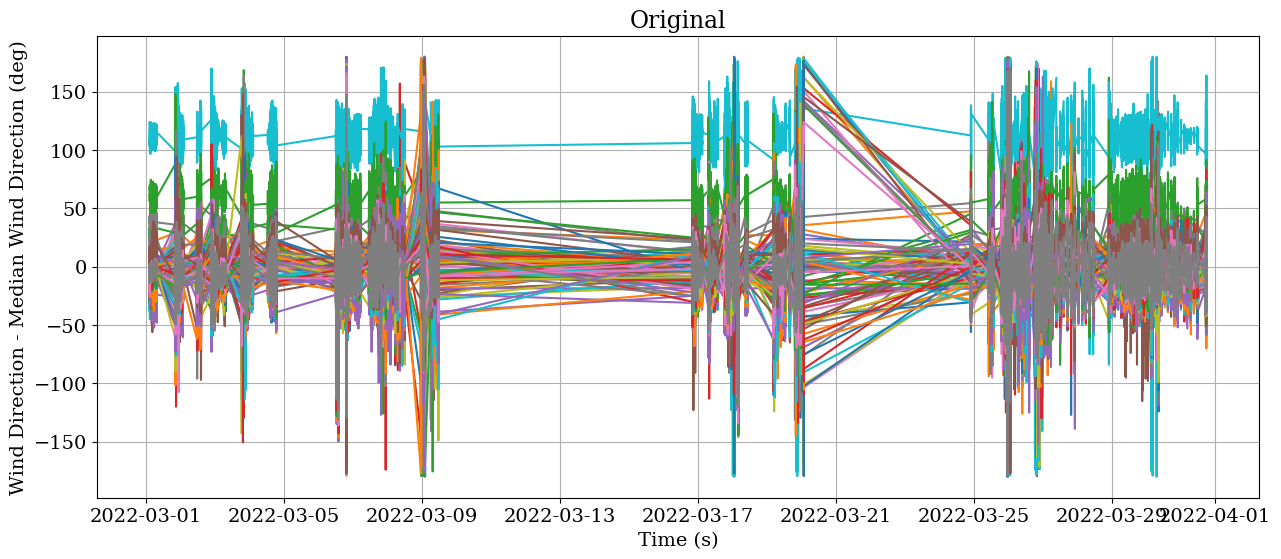

In [119]:
# turbine_ids = df_query.select("turbine_id").unique().collect(streaming=True).to_numpy()[:, 0]

# add the 3 degrees back to the wind direction signal
offset = 3.0
# TODO ERIC WHY ADD OFFSET
df_query2 = df_query.with_columns((cs.starts_with("wind_direction") + offset % 360.0))
# TODO make sure columns are ordered
wd_median = np.nanmedian(df_query2.select(cs.starts_with("wind_direction")).collect().to_numpy(), axis=1)
wd_median = np.degrees(np.arctan2(np.sin(np.radians(wd_median)), np.cos(np.radians(wd_median))))
wd_median = df_query2.select("time", cs.starts_with("wind_direction"), cs.starts_with("power_output")).with_columns(wd_median=wd_median)

yaw_median = np.nanmedian(df_query2.select(cs.starts_with("nacelle_direction")).collect().to_numpy(), axis=1)
yaw_median = np.degrees(np.arctan2(np.sin(np.radians(yaw_median)), np.cos(np.radians(yaw_median))))
yaw_median = df_query2.select("time", cs.starts_with("nacelle_direction"), cs.starts_with("power_output")).with_columns(yaw_median=yaw_median)

# TODO ERIC handle special cases
def plot_wind_offset(full_df, wd_median, title):
    fig, ax = plt.subplots(1, 1)
    for turbine_id in data_loader.turbine_ids:
        df = full_df.filter(pl.col(f"power_output_{turbine_id}") >= 0).select("time", f"wind_direction_{turbine_id}").collect()
                            
        ax.plot(df.select("time").to_numpy().flatten(), 
                DataFilter.wrap_180(
                            (df.select(f"wind_direction_{turbine_id}")
                            - wd_median.filter(pl.col(f"power_output_{turbine_id}") >= 0).select(f"wd_median").collect()).to_numpy().flatten()),
                            label=f"{turbine_id}")

    # ax.legend(ncol=8)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Wind Direction - Median Wind Direction (deg)")

    ax.set_title(title)

plot_wind_offset(df_query2, wd_median, "Original")

Turbine wt001 bias from median wind direction: 3.05 deg.
Turbine wt002 bias from median wind direction: 17.83 deg.
Turbine wt003 bias from median wind direction: -2.05 deg.
Turbine wt004 bias from median wind direction: -0.98 deg.
Turbine wt005 bias from median wind direction: 1.58 deg.
Turbine wt006 bias from median wind direction: -0.73 deg.
Turbine wt007 bias from median wind direction: 2.66 deg.
Turbine wt008 bias from median wind direction: 3.78 deg.
Turbine wt009 bias from median wind direction: -5.95 deg.
Turbine wt010 bias from median wind direction: 7.1 deg.
Turbine wt011 bias from median wind direction: -0.5 deg.
Turbine wt012 bias from median wind direction: 13.69 deg.
Turbine wt013 bias from median wind direction: 3.05 deg.
Turbine wt014 bias from median wind direction: 0.95 deg.
Turbine wt015 bias from median wind direction: 5.72 deg.
Turbine wt016 bias from median wind direction: -0.02 deg.
Turbine wt017 bias from median wind direction: 0.36 deg.
Turbine wt018 bias from m

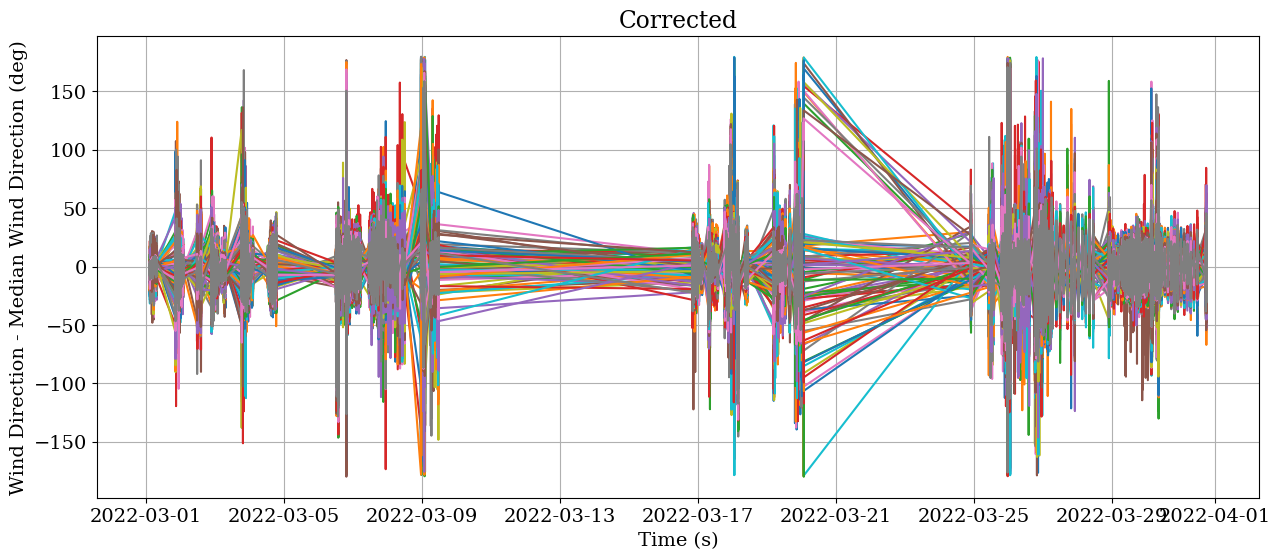

In [120]:
df_offsets = {"turbine_id": [], "northing_bias": []}

# remove biases from median direction
for turbine_id in data_loader.turbine_ids:
    df = df_query2.filter(pl.col(f"power_output_{turbine_id}") >= 0)\
                  .select("time", f"wind_direction_{turbine_id}", f"nacelle_direction_{turbine_id}").collect()
                   
    wd_bias = DataFilter.wrap_180(DataFilter.circ_mean(
        (df.select(f"wind_direction_{turbine_id}")
                                    - wd_median.filter(pl.col(f"power_output_{turbine_id}") >= 0).select(f"wd_median").collect()).to_numpy().flatten()))
    yaw_bias = DataFilter.wrap_180(DataFilter.circ_mean(
        (df.select(f"nacelle_direction_{turbine_id}")
                                    - yaw_median.filter(pl.col(f"power_output_{turbine_id}") >= 0).select(f"yaw_median").collect()).to_numpy().flatten()))

    df_offsets["turbine_id"].append(turbine_id)
    df_offsets["northing_bias"].append(np.round(0.5 * (wd_bias + yaw_bias), 2))
    
    # TODO QUESTION ERIC how to know if some turbines need exceptional cases??
    bias = -0.5 * (wd_bias + yaw_bias)
    df_query2 = df_query2.with_columns((pl.col(f"wind_direction_{turbine_id}") + bias) % 360.0, (pl.col(f"nacelle_direction_{turbine_id}") + bias) % 360.0)

    print(f"Turbine {turbine_id} bias from median wind direction: {df_offsets['northing_bias'][-1]} deg.")

df_offsets = pl.DataFrame(df_offsets)

plot_wind_offset(df_query2, wd_median, "Corrected")

# handle special case of turbine 39 with a couple change points
"""
tid = "wd_040"
df = DataInspector.collect_data(df=df_query2, 
                        features=["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"], 
                        mask=((pl.col("turbine_id") == tid) & (pl.col("power_output") >= 0)))
wd_bias_1 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] <= "2021-06-09 19:30"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] <= "2021-06-09 19:30") 
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

wd_bias_2 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-06-09 19:40")
    & (df['time'] <= "2021-09-14 19:50"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] >= "2021-06-09 19:30")
            & (wd_median['time'] <= "2021-09-14 19:50")   
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

wd_bias_3 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-09-14 20:00"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] >= "2021-09-14 20:00")
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_1 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] <= "2021-06-09 19:30"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] <= "2021-06-09 19:30") 
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_2 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-06-09 19:40")
    & (df['time'] <= "2021-09-14 19:50"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] >= "2021-06-09 19:30")
            & (yaw_median['time'] <= "2021-09-14 19:50")   
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_3 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-09-14 20:00"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] >= "2021-09-14 20:00")
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

cond = (df['time'] <= "2021-06-09 19:30")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_1 + yaw_bias_1)) % 360
df.loc[cond, "nacelle_direction"] = (df[cond, "nacelle_direction"] - 0.5 * (wd_bias_1 + yaw_bias_1)) % 360

cond = (df['time'] >= "2021-06-09 19:40") & (df['time'] <= "2021-09-14 19:50")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_2 + yaw_bias_2)) % 360
df.loc[cond, "nacelle_direction"] = (df.loc[cond, "nacelle_direction"] - 0.5 * (wd_bias_2 + yaw_bias_2)) % 360

cond = (df['time'] >= "2021-09-14 20:00")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_3 + yaw_bias_3)) % 360
df.loc[cond, "nacelle_direction"] = (df.loc[cond, "nacelle_direction"] - 0.5 * (wd_bias_3 + yaw_bias_3)) % 360

print("Biases from median wind direction for turbine 39:")

print(f"wd_bias_1: {wd_bias_1}")
print(f"wd_bias_2: {wd_bias_2}")
print(f"wd_bias_3: {wd_bias_3}")

print(f"yaw_bias_1: {yaw_bias_1}")
print(f"yaw_bias_2: {yaw_bias_2}")
print(f"yaw_bias_3: {yaw_bias_3}")

plt.figure()
for turbine_id in turbine_ids:
    plt.plot(df["time"], 
    DataFilter.wrap_180(df["wind_direction"].values - wd_median.loc[wd_median[f"power_output_{turbine_id}"] >= 0, "wind_direction"].values))

plt.xlabel("Time (s)")
plt.ylabel("Wind Direction - Median Wind Direction (deg)")
plt.title("Corrected")

# specific time of changepoints for turbine 39: 6/9 19:35:55; 9/14 19:55:02
"""
# make sure we have corrected the bias between wind direction and yaw position by adding 3 deg. to the wind direction
bias = 0
for turbine_id in data_loader.turbine_ids:
    df = df_query2.filter(pl.col(f"power_output_{turbine_id}") >= 0)\
                  .select("time", f"wind_direction_{turbine_id}", f"nacelle_direction_{turbine_id}")
                  
    bias += DataFilter.wrap_180(DataFilter.circ_mean(df.select(pl.col(f"wind_direction_{turbine_id}") - pl.col(f"nacelle_direction_{turbine_id}")).collect().to_numpy().flatten()))
    
print(f"Average Bias = {bias / len(data_loader.turbine_ids)} deg")

In [121]:
df_query = df_query2

### Find offset to true North using wake loss profiles

In [62]:
# Optimization function for finding waked direction
def gauss_corr(gauss_params, power_ratio):
    xs = np.array(range(-int((len(power_ratio) - 1) / 2), int((len(power_ratio) + 1) / 2), 1))
    gauss = -1 * gauss_params[2] * np.exp(-0.5 * ((xs - gauss_params[0]) / gauss_params[1])**2) + 1.
    return -1 * np.corrcoef(gauss, power_ratio)[0, 1]

In [ ]:
if False:
    # TODO ERIC indexing ?? Find offsets between direction of alignment between pairs of turbines 
    # and direction of peak wake losses. Use the average offset found this way 
    # to identify the Northing correction that should be applied to all turbines 
    # in the wind farm.
    from scipy.stats import norm
    from scipy.optimize import minimize

    from floris import FlorisModel
    fi = FlorisModel(data_inspector.farm_input_filepath)

    def compute_offsets(df, turbine_pairs:list[tuple[int, int]]=None):
        p_min = 100
        p_max = 3000

        prat_hfwdth = 30

        prat_turbine_pairs = turbine_pairs or [(61,60), (51,50), (43,42), (41,40), (18,19), (34,33), (17,16), (21,22), (87,86), (62,63), (32,33), (59,60), (42,43)]

        dir_offsets = []

        for i in range(len(prat_turbine_pairs)):
            i_up = prat_turbine_pairs[i][0]
            i_down = prat_turbine_pairs[i][1]

            dir_align = np.degrees(np.arctan2(fi.layout_x[i_up] - fi.layout_x[i_down], fi.layout_y[i_up] - fi.layout_y[i_down])) % 360

            # df_sub = df_10min.loc[(df_10min['pow_%03d' % i_up] >= p_min) & (df_10min['pow_%03d' % i_up] <= p_max) & (df_10min['pow_%03d' % i_down] >= 0)]
            tid_up =  f'wt{i_up:03d}'
            tid_down =  f'wt{i_down:03d}'

            if not (any(tid_up in feat for feat in data_loader.available_features) and any(tid_down in feat for feat in data_loader.available_features)):
                continue

            df_sub = df.filter((pl.col(f"power_output_{tid_up}") >= p_min) 
                                    & (pl.col(f"power_output_{tid_up}") <= p_max) 
                                    & (pl.col(f"power_output_{tid_down}") >= 0))
            
            # df_sub.loc[df_sub['wd_%03d' % i_up] >= 359.5,'wd_%03d' % i_up] = df_sub.loc[df_sub['wd_%03d' % i_up] >= 359.5,'wd_%03d' % i_up] - 360.0
            df_sub = df_sub.with_columns(pl.when((pl.col(f"wind_direction_{tid_up}") >= 359.5))\
                                            .then(pl.col(f"wind_direction_{tid_up}") - 360.0)\
                                            .otherwise(pl.col(f"wind_direction_{tid_up}")))

            # df_sub["wd_round"] = df_sub[f'wd_{i_up:03d}'].round()
            df_sub = df_sub.with_columns(pl.col(f"wind_direction_{tid_up}").round().alias(f"wd_round_{tid_up}"))

            df_sub = df_sub.group_by(f"wd_round_{tid_up}").mean().collect()

            p_ratio = df_sub.select(pl.col(f"power_output_{tid_down}") / pl.col(f"power_output_{tid_up}")).to_numpy().flatten()

            plt.figure()
            _, ax = plt.subplots(1,1)
            ax.plot(p_ratio, label="_nolegend_")
            ax.plot(dir_align * np.ones(2),[0,1.25], 'k--', label="Direction of Alignment")
            ax.grid()

            nadir = np.argmin(p_ratio[np.arange(int(np.round(dir_align)) - prat_hfwdth, int(np.round(dir_align)) + prat_hfwdth + 1) % 360])
            nadir = nadir + int(np.round(dir_align)) - prat_hfwdth

            opt_gauss_params = minimize(gauss_corr, [0, 5.0, 1.0], args=(p_ratio[np.arange(nadir - prat_hfwdth, nadir + prat_hfwdth + 1) % 360]),method='SLSQP')

            xs = np.array(range(-int((60 - 1) / 2),int((60 + 1) / 2),1))
            gauss = -1 * opt_gauss_params.x[2] * np.exp(-0.5 * ((xs - opt_gauss_params.x[0]) / opt_gauss_params.x[1])**2) + 1.

            ax.plot(xs + nadir, gauss,'k',label="_nolegend_")
            ax.plot(2 * [nadir + opt_gauss_params.x[0]], [0,1.25], 'r--',label="Direction of Measured Wake Center")
            ax.set_title(f"Turbine Pair: ({i_up}, {i_down})")
            ax.legend()
            ax.set_xlabel("Wind Direction [deg]")
            ax.set_ylabel("Power Ratio [-]")
            
            dir_offset = DataFilter.wrap_180(nadir + opt_gauss_params.x[0] - dir_align)
            print(f"Direction offset for turbine pair {prat_turbine_pairs[i]} = {dir_offset}")

            dir_offsets = dir_offsets + [dir_offset]

        if dir_offsets:
            print(f"Mean offset = {np.mean(dir_offsets)}")
            print(f"Std. Dev. = {np.std(dir_offsets)}")
            print(f"Min. = {np.min(dir_offsets)}")
            print(f"Max. = {np.max(dir_offsets)}")
            return dir_offsets
        else:
            print("No available turbine pairs!")

    dir_offsets = compute_offsets(df_query2)

In [66]:
if False:
    # Apply Northing offset to each turbine
    for turbine_id in data_loader.turbine_ids:
        df_query2 = df_query2.with_columns((pl.col(f"wind_direction_{turbine_id}") - np.mean(dir_offsets)) % 360)\
                            .with_columns((pl.col(f"nacelle_direction_{turbine_id}") - np.mean(dir_offsets)) % 360)

In [ ]:
if False
    #  Determine final wind direction correction for each turbine
    df_offsets = df_offsets.with_columns(northing_bias=DataFilter.wrap_180(df_offsets.select("northing_bias").to_numpy().flatten() + np.mean(dir_offsets)).round(2))

# df_offsets = df_offsets.set_index("Turbine ID")

# print("wd_bias_1: "+str(np.round(0.5*(wd_bias_1+yaw_bias_1) + np.mean(dir_offsets),2)))
# print("wd_bias_2: "+str(np.round(0.5*(wd_bias_2+yaw_bias_2) + np.mean(dir_offsets),2)))
# print("wd_bias_3: "+str(np.round(0.5*(wd_bias_3+yaw_bias_3) + np.mean(dir_offsets),2)))

df_offsets

In [ ]:
# verify that Northing calibration worked properly
if False:
    new_dir_offsets = compute_offsets(df_query2)

In [ ]:
df_query = df_query2

## Normalization & Feature Selection

In [127]:
is_numeric = (cs.starts_with("wind_direction") | cs.starts_with("wind_speed") | cs.starts_with("nacelle_direction"))
df_query = DataInspector.pivot_dataframe(DataInspector.unpivot_dataframe(df_query)\
             .select(pl.col("time"), pl.col("continuity_group"), pl.col("turbine_id"), (is_numeric - is_numeric.min()) / (is_numeric.max() - is_numeric.min()))
            )
# df_query = DataInspector.pivot_dataframe(DataInspector.unpivot_dataframe(df_query).select("time", "continuity_group", "turbine_id", cs.starts_with("wind_direction"), cs.starts_with("wind_speed"), cs.starts_with("nacelle_direction"))\
#                                       .select((is_numeric - is_numeric.min()) / (is_numeric.max() - is_numeric.min())))

df_query.collect().write_parquet(os.path.join(DATA_DIR, "normalized_data.parquet"), row_group_size=100000)

time,continuity_group_wt001,continuity_group_wt002,continuity_group_wt003,continuity_group_wt004,continuity_group_wt005,continuity_group_wt006,continuity_group_wt007,continuity_group_wt008,continuity_group_wt009,continuity_group_wt010,continuity_group_wt011,continuity_group_wt012,continuity_group_wt013,continuity_group_wt014,continuity_group_wt015,continuity_group_wt016,continuity_group_wt017,continuity_group_wt018,continuity_group_wt019,continuity_group_wt020,continuity_group_wt021,continuity_group_wt022,continuity_group_wt023,continuity_group_wt024,continuity_group_wt025,continuity_group_wt026,continuity_group_wt027,continuity_group_wt028,continuity_group_wt029,continuity_group_wt030,continuity_group_wt031,continuity_group_wt032,continuity_group_wt033,continuity_group_wt034,continuity_group_wt035,continuity_group_wt036,…,nacelle_direction_wt052,nacelle_direction_wt053,nacelle_direction_wt054,nacelle_direction_wt055,nacelle_direction_wt056,nacelle_direction_wt057,nacelle_direction_wt058,nacelle_direction_wt059,nacelle_direction_wt060,nacelle_direction_wt061,nacelle_direction_wt062,nacelle_direction_wt063,nacelle_direction_wt064,nacelle_direction_wt065,nacelle_direction_wt066,nacelle_direction_wt067,nacelle_direction_wt068,nacelle_direction_wt069,nacelle_direction_wt070,nacelle_direction_wt071,nacelle_direction_wt072,nacelle_direction_wt073,nacelle_direction_wt074,nacelle_direction_wt075,nacelle_direction_wt076,nacelle_direction_wt077,nacelle_direction_wt078,nacelle_direction_wt079,nacelle_direction_wt080,nacelle_direction_wt081,nacelle_direction_wt082,nacelle_direction_wt083,nacelle_direction_wt084,nacelle_direction_wt085,nacelle_direction_wt086,nacelle_direction_wt087,nacelle_direction_wt088
datetime[μs],i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2022-03-01 02:48:20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0.594148,0.605171,0.595852,0.591828,0.597816,0.589134,0.60163,0.595872,0.59591,0.599258,0.608421,0.591962,0.593161,0.584182,0.59732,0.593948,0.600638,0.588524,0.595867,0.611452,0.586662,0.585141,0.591124,0.590908,0.595981,0.612724,0.585196,0.602831,0.581701,0.597861,0.585937,0.589166,0.59234,0.59123,0.575868,0.583065,0.576949
2022-03-01 02:48:25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0.594148,0.605171,0.595852,0.591828,0.597816,0.589134,0.60163,0.595872,0.59591,0.599258,0.608421,0.591962,0.593161,0.584182,0.59732,0.593948,0.600638,0.588524,0.595867,0.611452,0.586662,0.585141,0.591124,0.590908,0.595981,0.612724,0.587974,0.602831,0.581701,0.597861,0.585937,0.589166,0.59234,0.59123,0.575868,0.583065,0.576949
2022-03-01 02:48:30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0.594148,0.605171,0.595852,0.591828,0.597816,0.589134,0.60163,0.595872,0.59591,0.599258,0.608421,0.591962,0.593161,0.584182,0.59732,0.593948,0.600638,0.588524,0.595867,0.611452,0.586662,0.585141,0.591124,0.590908,0.595981,0.612724,0.596308,0.602831,0.581701,0.597861,0.585937,0.589166,0.59234,0.59123,0.575868,0.583065,0.576949
2022-03-01 02:48:35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0.594148,0.605171,0.595852,0.586272,0.589482,0.589134,0.60163,0.595872,0.59591,0.599258,0.608421,0.591962,0.593161,0.584182,0.59732,0.593948,0.600638,0.588524,0.595867,0.611452,0.586662,0.585141,0.591124,0.590908,0.595981,0.612724,0.596308,0.602831,0.581701,0.597861,0.585937,0.589166,0.59234,0.588452,0.575868,0.583065,0.576949
2022-03-01 02:48:40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0.594148,0.607949,0.595852,0.580716,0.589482,0.589134,0.60163,0.595872,0.601466,0.599258,0.608421,0.591962,0.593161,0.584182,0.59732,0.593948,0.600638,0.588524,0.595867,0.611452,0.586662,